In [1]:
#!/usr/bin/env python3
"""
Head-to-Head Comparison: Equivariant vs Non-Equivariant Models

This notebook cell version:
- Allows interactive execution without command-line arguments
- Preserves all functionality of compare_models.py
"""

import sys
import argparse
from pathlib import Path
import numpy as np
import pickle
import json
import time
from typing import Dict, Tuple, Any, List
from dataclasses import dataclass, asdict

# Add mmml to path (adjust if necessary)
repo_root = Path(".").resolve().parent.parent.parent
sys.path.insert(0, str(repo_root))

import jax
import jax.numpy as jnp
from scipy.spatial.transform import Rotation

# Import training script components
from trainer import (
    JointPhysNetDCMNet,
    JointPhysNetNonEquivariant,
    load_combined_data,
    train_model,
    create_optimizer,
    get_recommended_optimizer_config,
    LossTerm,
)

try:
    import matplotlib.pyplot as plt
    import matplotlib
    matplotlib.use('Agg')
    HAS_MATPLOTLIB = True
except ImportError:
    HAS_MATPLOTLIB = False


@dataclass
class ModelMetrics:
    """Store metrics for a single model."""
    name: str
    training_time: float
    inference_time: float
    memory_usage_mb: float
    num_parameters: int
    val_energy_mae: float
    val_forces_mae: float
    val_dipole_mae: float
    val_esp_mae: float
    rotation_error_dipole: float
    rotation_error_esp: float
    translation_error_dipole: float
    translation_error_esp: float


def apply_rotation(positions: np.ndarray, rotation_matrix: np.ndarray) -> np.ndarray:
    return np.einsum('ij,snj->sni', rotation_matrix, positions)


def apply_translation(positions: np.ndarray, translation: np.ndarray) -> np.ndarray:
    return positions + translation[None, None, :]


def generate_random_rotation() -> np.ndarray:
    return Rotation.random().as_matrix()


def predict_single(model: Any, params: Any, R: np.ndarray, Z: np.ndarray, N: np.ndarray, vdw_surface: np.ndarray) -> Dict[str, np.ndarray]:
    import e3x

    natoms = R.shape[1]
    batch_size = 1
    positions_flat = R.reshape(-1, 3)
    atomic_numbers_flat = Z.reshape(-1)

    cutoff = 10.0
    n_atoms = int(N[0])
    dst_idx_list = []
    src_idx_list = []
    for i in range(n_atoms):
        for j in range(n_atoms):
            if i != j:
                dist = np.linalg.norm(R[0, i] - R[0, j])
                if dist < cutoff:
                    dst_idx_list.append(i)
                    src_idx_list.append(j)

    dst_idx = jnp.array(dst_idx_list, dtype=jnp.int32)
    src_idx = jnp.array(src_idx_list, dtype=jnp.int32)

    batch_segments = jnp.zeros(natoms, dtype=jnp.int32)
    batch_mask = jnp.ones(batch_size)
    atom_mask = (jnp.arange(natoms) < n_atoms).astype(jnp.float32)

    output = model.apply(
        params,
        atomic_numbers=jnp.array(atomic_numbers_flat),
        positions=jnp.array(positions_flat),
        dst_idx=dst_idx,
        src_idx=src_idx,
        batch_segments=batch_segments,
        batch_size=batch_size,
        batch_mask=batch_mask,
        atom_mask=atom_mask,
    )

    mono_dist = output['mono_dist'].reshape(batch_size, natoms, -1)
    dipo_dist = output['dipo_dist'].reshape(batch_size, natoms, -1, 3)

    esp_pred = calculate_esp(
        mono_dist[0],
        dipo_dist[0],
        vdw_surface[0],
        atom_mask,
    )

    return {
        'dipole': np.array(output['dipoles_dcmnet'][0]),
        'esp': np.array(esp_pred),
        'energy': np.array(output['energy'][0]),
    }


def calculate_esp(charges: jnp.ndarray, positions: jnp.ndarray, grid_points: jnp.ndarray, atom_mask: jnp.ndarray) -> jnp.ndarray:
    natoms, n_dcm = charges.shape
    ngrid = grid_points.shape[0]

    charges_flat = charges.reshape(-1)
    positions_flat = positions.reshape(-1, 3)
    atom_mask_expanded = jnp.repeat(atom_mask, n_dcm)
    charges_masked = charges_flat * atom_mask_expanded

    diff = grid_points[:, None, :] - positions_flat[None, :, :]
    distances = jnp.linalg.norm(diff, axis=-1)
    distances = jnp.where(distances < 1e-6, 1e6, distances)

    distances_bohr = distances * 1.88973
    esp = jnp.sum(charges_masked[None, :] / distances_bohr, axis=1)
    return esp


def test_equivariance(model, params, test_data, num_test_samples=10, seed=42):
    rng = np.random.RandomState(seed)
    n_available = len(test_data['E'])
    test_indices = rng.choice(n_available, size=min(num_test_samples, n_available), replace=False)

    rotation_errors_dipole = []
    rotation_errors_esp = []
    translation_errors_dipole = []
    translation_errors_esp = []

    for idx in test_indices:
        R = test_data['R'][idx:idx+1]
        Z = test_data['Z'][idx:idx+1]
        N = test_data['N'][idx:idx+1]
        vdw_surface = test_data['vdw_surface'][idx:idx+1]

        output_orig = predict_single(model, params, R, Z, N, vdw_surface)

        rot_matrix = generate_random_rotation()
        R_rot = apply_rotation(R, rot_matrix)
        vdw_rot = apply_rotation(vdw_surface, rot_matrix)
        output_rot = predict_single(model, params, R_rot, Z, N, vdw_rot)

        dipole_orig = output_orig['dipole']
        dipole_rot = output_rot['dipole']
        dipole_expected = np.dot(rot_matrix, dipole_orig)
        rotation_error_dipole = np.linalg.norm(dipole_rot - dipole_expected)
        rotation_errors_dipole.append(rotation_error_dipole)

        esp_orig = output_orig['esp']
        esp_rot = output_rot['esp']
        rotation_error_esp = np.mean(np.abs(esp_rot - esp_orig))
        rotation_errors_esp.append(rotation_error_esp)

        translation = rng.randn(3) * 5.0
        R_trans = apply_translation(R, translation)
        vdw_trans = apply_translation(vdw_surface, translation)
        output_trans = predict_single(model, params, R_trans, Z, N, vdw_trans)

        dipole_trans = output_trans['dipole']
        translation_error_dipole = np.linalg.norm(dipole_trans - dipole_orig)
        translation_errors_dipole.append(translation_error_dipole)

        esp_trans = output_trans['esp']
        translation_error_esp = np.mean(np.abs(esp_trans - esp_orig))
        translation_errors_esp.append(translation_error_esp)

    return {
        'rotation_error_dipole': float(np.mean(rotation_errors_dipole)),
        'rotation_error_esp': float(np.mean(rotation_errors_esp)),
        'translation_error_dipole': float(np.mean(translation_errors_dipole)),
        'translation_error_esp': float(np.mean(translation_errors_esp)),
    }


def measure_inference_time(model, params, test_data, num_samples=50):
    indices = np.random.choice(len(test_data['E']), size=min(num_samples, len(test_data['E'])), replace=False)
    times = []
    for idx in indices:
        R = test_data['R'][idx:idx+1]
        Z = test_data['Z'][idx:idx+1]
        N = test_data['N'][idx:idx+1]
        vdw_surface = test_data['vdw_surface'][idx:idx+1]
        start = time.time()
        _ = predict_single(model, params, R, Z, N, vdw_surface)
        times.append(time.time() - start)
    return float(np.mean(times))


def count_parameters(params):
    return sum(x.size for x in jax.tree_util.tree_leaves(params))


# ========== Example interactive setup for notebook ==========

class Args:
    train_efd = Path("/scicore/home/meuwly/boitti0000/mmml/examples/co2/preclassified_data/energies_forces_dipoles_train.npz")
    train_esp = Path("/scicore/home/meuwly/boitti0000/mmml/examples/co2/preclassified_data/grids_esp_train.npz")
    valid_efd = Path("/scicore/home/meuwly/boitti0000/mmml/examples/co2/preclassified_data/energies_forces_dipoles_valid.npz")
    valid_esp = Path("/scicore/home/meuwly/boitti0000/mmml/examples/co2/preclassified_data/grids_esp_valid.npz")
    epochs = 1000
    batch_size = 1000
    seed = 42
    physnet_features = 128
    dcmnet_features = 128
    n_dcm = 2
    comparison_name = "interactive_comparison3"
    output_dir = Path("comparisons")
    skip_training = True
    equivariance_samples = 10

args = Args()
print("Notebook arguments initialized. Ready to run comparison interactively.")


Notebook arguments initialized. Ready to run comparison interactively.


In [2]:
import jax
jax.devices()

[CudaDevice(id=0)]

In [3]:
args

In [4]:
from compare_models import *
get_recommended_optimizer_config?

Signature:
get_recommended_optimizer_config(
    dataset_size: int,
    num_features: int,
    num_atoms: int,
    optimizer_name: str = 'adamw',
) -> Dict[str, Any]
Docstring:
Get recommended optimizer hyperparameters based on dataset properties.

Args:
    dataset_size: Number of training samples
    num_features: Total number of model features (PhysNet + DCMNet)
    num_atoms: Maximum number of atoms in molecules
    optimizer_name: One of 'adam', 'adamw', 'rmsprop', 'muon'

Returns:
    Dictionary with recommended hyperparameters
File:      ~/mmml/examples/co2/dcmnet_physnet_train/trainer.py
Type:      function

In [5]:

# Create output directory
output_dir = args.output_dir / args.comparison_name
output_dir.mkdir(exist_ok=True, parents=True)

print("="*70)
print("HEAD-TO-HEAD MODEL COMPARISON")
print("="*70)
print(f"\nComparison: {args.comparison_name}")
print(f"Output directory: {output_dir}")

# Load data
print(f"\n{'#'*70}")
print("# Loading Data")
print(f"{'#'*70}\n")

train_data = load_combined_data(args.train_efd, args.train_esp, verbose=True)
valid_data = load_combined_data(args.valid_efd, args.valid_esp, verbose=True)

print(f"\n✅ Data loaded:")
print(f"  Training samples: {len(train_data['E'])}")
print(f"  Validation samples: {len(valid_data['E'])}")

# Get dataset properties
natoms = train_data['R'].shape[1]
max_atomic_number = int(max(np.max(train_data['Z']), np.max(valid_data['Z'])))

# Shared PhysNet config
physnet_config = {
    'features': args.physnet_features,
    'max_degree': 0,
    'num_iterations': 3,
    'num_basis_functions': 64,
    'cutoff': 6.0,
    'max_atomic_number': max_atomic_number,
    'charges': True,
    'natoms': natoms,
    'total_charge': 0.0,
    'n_res': 3,
    'zbl': False,
    'use_energy_bias': True,
    'debug': False,
    'efa': False,
}

# Get recommended optimizer settings
recommended_config = get_recommended_optimizer_config(
    dataset_size=len(train_data['E']),
    num_features=args.physnet_features + args.dcmnet_features,
    num_atoms=natoms,
    optimizer_name='adam',
)

# Model configurations
dcmnet_config = {
    'features': args.dcmnet_features,
    'max_degree': 2,
    'num_iterations': 2,
    'num_basis_functions': 64,
    'cutoff': 10.0,
    'max_atomic_number': max_atomic_number,
    'n_dcm': args.n_dcm,
    'include_pseudotensors': False,
}

noneq_config = {
    'features': args.dcmnet_features * 2,  
    'n_dcm': args.n_dcm,
    'max_atomic_number': max_atomic_number,
    'num_layers': 5,
    'max_displacement': 1.0,
}

results = {}

# ==================================================================
# Train/Load DCMNet (Equivariant)
# ==================================================================
print(f"\n{'#'*70}")
print("# DCMNet (Equivariant) Model")
print(f"{'#'*70}\n")

dcm_ckpt_dir = output_dir / 'dcmnet_equivariant'
dcm_ckpt_dir.mkdir(exist_ok=True, parents=True)

model_dcm = JointPhysNetDCMNet(
    physnet_config=physnet_config,
    dcmnet_config=dcmnet_config,
    mix_coulomb_energy=False,
)

if args.skip_training and (dcm_ckpt_dir / 'best_params.pkl').exists():
    print(f"⏩ Loading existing checkpoint: {dcm_ckpt_dir / 'best_params.pkl'}")
    with open(dcm_ckpt_dir / 'best_params.pkl', 'rb') as f:
        params_dcm = pickle.load(f)
    training_time_dcm = 0.0
else:
    print("🏋️  Training DCMNet...")
    start_time = time.time()
    
    # Create loss terms for training
    dipole_terms = (
        LossTerm(source='physnet', weight=25.0, metric='l2', name='physnet'),
    )
    esp_terms = (
        LossTerm(source='dcmnet', weight=10000.0, metric='l2', name='dcmnet'),
    )
    
    params_dcm = train_model(
        model=model_dcm,
        train_data=train_data,
        valid_data=valid_data,
        num_epochs=args.epochs,
        batch_size=args.batch_size,
        learning_rate=recommended_config['learning_rate']*1.5,
        weight_decay=recommended_config['weight_decay'],
        energy_w=10.0,
        forces_w=50.0,
        dipole_w=25.0,
        esp_w=10000.0,
        mono_w=100.0,
        n_dcm=args.n_dcm,
        cutoff=10.0,
        seed=args.seed,
        ckpt_dir=dcm_ckpt_dir.parent,
        name=dcm_ckpt_dir.name,
        print_freq=5,
        dipole_terms=dipole_terms,
        esp_terms=esp_terms,
        optimizer_name='adam',
        optimizer_kwargs={'b1': 0.9, 'b2': 0.999},
    )
    
    training_time_dcm = time.time() - start_time
    print(f"\n✅ DCMNet training completed in {training_time_dcm/3600:.2f} hours")

# ==================================================================
# Train/Load Non-Equivariant
# ==================================================================
print(f"\n{'#'*70}")
print("# Non-Equivariant Model")
print(f"{'#'*70}\n")

noneq_ckpt_dir = output_dir / 'noneq_model'
noneq_ckpt_dir.mkdir(exist_ok=True, parents=True)

model_noneq = JointPhysNetNonEquivariant(
    physnet_config=physnet_config,
    noneq_config=noneq_config,
    mix_coulomb_energy=False,
)

if args.skip_training and (noneq_ckpt_dir / 'best_params.pkl').exists():
    print(f"⏩ Loading existing checkpoint: {noneq_ckpt_dir / 'best_params.pkl'}")
    with open(noneq_ckpt_dir / 'best_params.pkl', 'rb') as f:
        params_noneq = pickle.load(f)
    training_time_noneq = 0.0
else:
    print("🏋️  Training Non-Equivariant model...")
    start_time = time.time()
    
    # Create loss terms for training (same as DCMNet for fair comparison)
    dipole_terms = (
        LossTerm(source='physnet', weight=25.0, metric='l2', name='physnet'),
    )
    esp_terms = (
        LossTerm(source='dcmnet', weight=10000.0, metric='l2', name='dcmnet'),
    )
    
    params_noneq = train_model(
        model=model_noneq,
        train_data=train_data,
        valid_data=valid_data,
        num_epochs=args.epochs,
        batch_size=args.batch_size,
        learning_rate=recommended_config['learning_rate']*1.5,
        weight_decay=recommended_config['weight_decay'],
        energy_w=10.0,
        forces_w=50.0,
        dipole_w=25.0,
        esp_w=10000.0,
        mono_w=100.0,
        n_dcm=args.n_dcm,
        cutoff=10.0,
        seed=args.seed,
        ckpt_dir=noneq_ckpt_dir.parent,
        name=noneq_ckpt_dir.name,
        print_freq=5,
        dipole_terms=dipole_terms,
        esp_terms=esp_terms,
        optimizer_name='adam',
        optimizer_kwargs={'b1': 0.9, 'b2': 0.999},
    )
    
    training_time_noneq = time.time() - start_time
    print(f"\n✅ Non-Equivariant training completed in {training_time_noneq/3600:.2f} hours")


HEAD-TO-HEAD MODEL COMPARISON

Comparison: interactive_comparison3
Output directory: comparisons/interactive_comparison3

######################################################################
# Loading Data
######################################################################

  Loading EFD: /scicore/home/meuwly/boitti0000/mmml/examples/co2/preclassified_data/energies_forces_dipoles_train.npz
  Loading ESP: /scicore/home/meuwly/boitti0000/mmml/examples/co2/preclassified_data/grids_esp_train.npz
  ✅ Subtracted atomic energies (now relative to isolated atoms)
  Aligning ESP grids to molecular reference frames...
  ✅ Aligned ESP grids to molecular reference frames
     Sample 0 - Atom COM: [0.         0.14525378 0.11470596]
     Sample 0 - Grid COM before: [3.25342429 3.24367862 3.3973045 ]
     Sample 0 - Grid COM after: [2.56091444e-16 1.45253775e-01 1.14705956e-01]
     Sample 0 - Offset corrected: [3.25342429 3.09842484 3.28259855] Å
  Combined data shapes:
    R: (8000, 60, 3)
    

In [ ]:

# ==================================================================
# Run Equivariance Tests
# ==================================================================
print(f"\n{'#'*70}")
print("# Equivariance Testing")
print(f"{'#'*70}")

print("\n--- DCMNet (Equivariant) ---")
equivariance_dcm = test_equivariance(
    model_dcm,
    params_dcm,
    valid_data,
    num_test_samples=args.equivariance_samples,
    seed=args.seed,
)

print("\n--- Non-Equivariant ---")
equivariance_noneq = test_equivariance(
    model_noneq,
    params_noneq,
    valid_data,
    num_test_samples=args.equivariance_samples,
    seed=args.seed,
)

# ==================================================================
# Measure Performance
# ==================================================================
print(f"\n{'#'*70}")
print("# Performance Benchmarking")
print(f"{'#'*70}\n")

# print("Measuring inference times...")
# inference_time_dcm = measure_inference_time(model_dcm, params_dcm, valid_data, num_samples=50)
# inference_time_noneq = measure_inference_time(model_noneq, params_noneq, valid_data, num_samples=50)

# print(f"  DCMNet:        {inference_time_dcm*1000:.2f} ms/sample")
# print(f"  Non-Eq:        {inference_time_noneq*1000:.2f} ms/sample")
# print(f"  Speedup:       {inference_time_dcm/inference_time_noneq:.2f}×")

num_params_dcm = count_parameters(params_dcm)
num_params_noneq = count_parameters(params_noneq)

print(f"\nParameter counts:")
print(f"  DCMNet:        {num_params_dcm:,} parameters")
print(f"  Non-Eq:        {num_params_noneq:,} parameters")
print(f"  Reduction:     {(1 - num_params_noneq/num_params_dcm)*100:.1f}%")

# Load validation metrics from history (with fallback for missing files)
history_dcm_path = dcm_ckpt_dir / 'history.json'
history_noneq_path = noneq_ckpt_dir / 'history.json'

if history_dcm_path.exists():
    with open(history_dcm_path, 'r') as f:
        history_dcm = json.load(f)
    best_epoch_dcm = np.argmin(history_dcm['val_loss'])
    val_energy_mae_dcm = history_dcm['val_energy_mae'][best_epoch_dcm]
    val_forces_mae_dcm = history_dcm['val_forces_mae'][best_epoch_dcm]
    val_dipole_mae_dcm = history_dcm['val_dipole_mae'][best_epoch_dcm]
    val_esp_mae_dcm = history_dcm['val_esp_mae'][best_epoch_dcm]
else:
    print(f"\n⚠️  Warning: No history file found for DCMNet at {history_dcm_path}")
    print("   Using placeholder values (0.0) for validation metrics.")
    print("   Rerun comparison to get full metrics.")
    val_energy_mae_dcm = 0.0
    val_forces_mae_dcm = 0.0
    val_dipole_mae_dcm = 0.0
    val_esp_mae_dcm = 0.0

if history_noneq_path.exists():
    with open(history_noneq_path, 'r') as f:
        history_noneq = json.load(f)
    best_epoch_noneq = np.argmin(history_noneq['val_loss'])
    val_energy_mae_noneq = history_noneq['val_energy_mae'][best_epoch_noneq]
    val_forces_mae_noneq = history_noneq['val_forces_mae'][best_epoch_noneq]
    val_dipole_mae_noneq = history_noneq['val_dipole_mae'][best_epoch_noneq]
    val_esp_mae_noneq = history_noneq['val_esp_mae'][best_epoch_noneq]
else:
    print(f"\n⚠️  Warning: No history file found for Non-Eq at {history_noneq_path}")
    print("   Using placeholder values (0.0) for validation metrics.")
    print("   Rerun comparison to get full metrics.")
    val_energy_mae_noneq = 0.0
    val_forces_mae_noneq = 0.0
    val_dipole_mae_noneq = 0.0
    val_esp_mae_noneq = 0.0

# Create metrics objects
metrics_dcm = ModelMetrics(
    name='DCMNet (Equivariant)',
    training_time=0,
    inference_time=0,
    memory_usage_mb=0.0,  # Would need profiling
    num_parameters=num_params_dcm,
    val_energy_mae=val_energy_mae_dcm,
    val_forces_mae=val_forces_mae_dcm,
    val_dipole_mae=val_dipole_mae_dcm,
    val_esp_mae=val_esp_mae_dcm,
    rotation_error_dipole=equivariance_dcm['rotation_error_dipole'],
    rotation_error_esp=equivariance_dcm['rotation_error_esp'],
    translation_error_dipole=equivariance_dcm['translation_error_dipole'],
    translation_error_esp=equivariance_dcm['translation_error_esp'],
)

metrics_noneq = ModelMetrics(
    name='Non-Equivariant',
    # training_time=training_time_noneq,
    # inference_time=inference_time_noneq,
    training_time=0,
    inference_time=0,
    memory_usage_mb=0.0,
    num_parameters=num_params_noneq,
    val_energy_mae=val_energy_mae_noneq,
    val_forces_mae=val_forces_mae_noneq,
    val_dipole_mae=val_dipole_mae_noneq,
    val_esp_mae=val_esp_mae_noneq,
    rotation_error_dipole=equivariance_noneq['rotation_error_dipole'],
    rotation_error_esp=equivariance_noneq['rotation_error_esp'],
    translation_error_dipole=equivariance_noneq['translation_error_dipole'],
    translation_error_esp=equivariance_noneq['translation_error_esp'],
)

# ==================================================================
# Generate Comparison Report
# ==================================================================
print(f"\n{'#'*70}")
print("# Final Comparison Report")
print(f"{'#'*70}\n")

print("VALIDATION PERFORMANCE:")
print(f"  Energy MAE:  DCMNet={metrics_dcm.val_energy_mae:.4f}, Non-Eq={metrics_noneq.val_energy_mae:.4f}")
print(f"  Forces MAE:  DCMNet={metrics_dcm.val_forces_mae:.4f}, Non-Eq={metrics_noneq.val_forces_mae:.4f}")
print(f"  Dipole MAE:  DCMNet={metrics_dcm.val_dipole_mae:.4f}, Non-Eq={metrics_noneq.val_dipole_mae:.4f}")
print(f"  ESP MAE:     DCMNet={metrics_dcm.val_esp_mae:.4f}, Non-Eq={metrics_noneq.val_esp_mae:.4f}")

print("\nEQUIVARIANCE (Rotation):")
print(f"  Dipole:      DCMNet={metrics_dcm.rotation_error_dipole:.6f}, Non-Eq={metrics_noneq.rotation_error_dipole:.6f}")
print(f"  ESP:         DCMNet={metrics_dcm.rotation_error_esp:.6f}, Non-Eq={metrics_noneq.rotation_error_esp:.6f}")
print("  ⚠️  DCMNet should have near-zero rotation error (equivariant)")
print("  ⚠️  Non-Eq will have larger error (not equivariant)")

print("\nINVARIANCE (Translation):")
print(f"  Dipole:      DCMNet={metrics_dcm.translation_error_dipole:.6f}, Non-Eq={metrics_noneq.translation_error_dipole:.6f}")
print(f"  ESP:         DCMNet={metrics_dcm.translation_error_esp:.6f}, Non-Eq={metrics_noneq.translation_error_esp:.6f}")
print("  ✅ Both should have near-zero translation error")

# print("\nCOMPUTATIONAL EFFICIENCY:")
# if training_time_dcm > 0 and training_time_noneq > 0:
#     speedup = training_time_dcm / training_time_noneq
#     print(f"  Training:    DCMNet={training_time_dcm/3600:.2f}h, Non-Eq={training_time_noneq/3600:.2f}h ({speedup:.2f}× speedup)")
# print(f"  Inference:   DCMNet={inference_time_dcm*1000:.2f}ms, Non-Eq={inference_time_noneq*1000:.2f}ms ({inference_time_dcm/inference_time_noneq:.2f}× speedup)")
# print(f"  Parameters:  DCMNet={num_params_dcm:,}, Non-Eq={num_params_noneq:,} ({(1-num_params_noneq/num_params_dcm)*100:.1f}% reduction)")

# Save results
# Convert Path objects to strings for JSON serialization
args_dict = {}
for key, value in vars(args).items():
    if isinstance(value, Path):
        args_dict[key] = str(value)
    else:
        args_dict[key] = value

results = {
    'dcmnet': asdict(metrics_dcm),
    'noneq': asdict(metrics_noneq),
    'args': args_dict,
}

with open(output_dir / 'comparison_results.json', 'w') as f:
    json.dump(results, f, indent=2)

print(f"\n✅ Results saved to: {output_dir / 'comparison_results.json'}")

# Generate plots
print(f"\n{'#'*70}")
print("# Generating Comparison Plots")
print(f"{'#'*70}\n")

plot_comparison(metrics_dcm, metrics_noneq, output_dir)

print(f"\n{'='*70}")
print("✅ COMPARISON COMPLETE!")
print(f"{'='*70}")
print(f"\nAll results saved to: {output_dir}")
print("\nGenerated files:")
print(f"  - comparison_results.json")
print(f"  - performance_comparison.png")
print(f"  - efficiency_comparison.png")
print(f"  - equivariance_comparison.png")
print(f"  - dcmnet_equivariant/ (checkpoint)")
print(f"  - noneq_model/ (checkpoint)")


In [ ]:
test_efd = Path("/scicore/home/meuwly/boitti0000/mmml/examples/co2/preclassified_data/energies_forces_dipoles_test.npz")
test_esp = Path("/scicore/home/meuwly/boitti0000/mmml/examples/co2/preclassified_data/grids_esp_test.npz")

In [ ]:
test_data = load_combined_data(test_efd, test_esp, verbose=True)

In [8]:
print(f"\n{'#'*70}")
print("# Equivariance Testing")
print(f"{'#'*70}")
NTEST = 10
print("\n--- DCMNet (Equivariant) ---")
equivariance_dcm = test_equivariance(
    model_dcm,
    params_dcm,
    test_data,
    num_test_samples=NTEST,
    seed=args.seed,
)

print("\n--- Non-Equivariant ---")
equivariance_noneq = test_equivariance(
    model_noneq,
    params_noneq,
    test_data,
    num_test_samples=NTEST,
    seed=args.seed,
)



######################################################################
# Equivariance Testing
######################################################################

--- DCMNet (Equivariant) ---

Testing Equivariance on 10 samples

Rotation Equivariance:
  Dipole error: 0.000389 ± 0.000219 e·Å
  ESP error:    0.000034 ± 0.000024 Ha/e

Translation Invariance:
  Dipole error: 0.000001 ± 0.000002 e·Å
  ESP error:    0.000000 ± 0.000000 Ha/e

Reference Property Errors:
  Energy MAE: 0.086115 ± 0.095432 eV
  Forces MAE: 0.243193 ± 0.217913 eV/Å
  Dipole MAE: 0.117829 ± 0.053204 e·Å
  ESP MAE:    0.013486 ± 0.001340 Ha/e

--- Non-Equivariant ---

Testing Equivariance on 10 samples

Rotation Equivariance:
  Dipole error: 0.066709 ± 0.030806 e·Å
  ESP error:    0.004328 ± 0.000941 Ha/e

Translation Invariance:
  Dipole error: 0.000020 ± 0.000046 e·Å
  ESP error:    0.000003 ± 0.000006 Ha/e

Reference Property Errors:
  Energy MAE: 0.095156 ± 0.078787 eV
  Forces MAE: 0.176225 ± 0.099364 eV/Å


In [9]:
import pandas as pd
pd.DataFrame([equivariance_dcm, equivariance_noneq])

,rotation_error_dipole,rotation_error_esp,translation_error_dipole,translation_error_esp,rotation_error_dipole_std,rotation_error_esp_std,translation_error_dipole_std,translation_error_esp_std,energy_mae,forces_mae,dipole_mae,esp_mae,energy_mae_std,forces_mae_std,dipole_mae_std,esp_mae_std,all_output_orig,all_output_rot,all_output_trans
0,0.000389,0.000034,0.000001,5.812720e-08,0.000219,0.000024,0.000002,7.820010e-08,0.086115,0.243193,0.117829,0.013486,0.095432,0.217913,0.053204,0.001340,"[{'dipole': [0.0, -0.3893087, -0.2860123], 'es...","[{'dipole': [-0.18399262, -0.40120593, -0.1960...","[{'dipole': [0.0, -0.3893084, -0.28601193], 'e..."
1,0.066709,0.004328,0.000020,2.525994e-06,0.030806,0.000941,0.000046,5.723092e-06,0.095156,0.176225,0.125213,0.013050,0.078787,0.099364,0.050117,0.001085,"[{'dipole': [-0.0037734732, -0.3266114, -0.296...","[{'dipole': [-0.20759009, -0.33948642, -0.1979...","[{'dipole': [-0.003773488, -0.3266115, -0.2967..."


In [10]:
import pandas as pd
df = pd.DataFrame([equivariance_dcm, equivariance_noneq], index=["EQV", "NEQV"])
df

,rotation_error_dipole,rotation_error_esp,translation_error_dipole,translation_error_esp,rotation_error_dipole_std,rotation_error_esp_std,translation_error_dipole_std,translation_error_esp_std,energy_mae,forces_mae,dipole_mae,esp_mae,energy_mae_std,forces_mae_std,dipole_mae_std,esp_mae_std,all_output_orig,all_output_rot,all_output_trans
EQV,0.000389,0.000034,0.000001,5.812720e-08,0.000219,0.000024,0.000002,7.820010e-08,0.086115,0.243193,0.117829,0.013486,0.095432,0.217913,0.053204,0.001340,"[{'dipole': [0.0, -0.3893087, -0.2860123], 'es...","[{'dipole': [-0.18399262, -0.40120593, -0.1960...","[{'dipole': [0.0, -0.3893084, -0.28601193], 'e..."
NEQV,0.066709,0.004328,0.000020,2.525994e-06,0.030806,0.000941,0.000046,5.723092e-06,0.095156,0.176225,0.125213,0.013050,0.078787,0.099364,0.050117,0.001085,"[{'dipole': [-0.0037734732, -0.3266114, -0.296...","[{'dipole': [-0.20759009, -0.33948642, -0.1979...","[{'dipole': [-0.003773488, -0.3266115, -0.2967..."


In [11]:
keys_to_see = ['rotation_error_dipole', 'rotation_error_esp',
       'translation_error_dipole', 'translation_error_esp',
       'rotation_error_dipole_std', 'rotation_error_esp_std',
       'translation_error_dipole_std', 'translation_error_esp_std',
       'energy_mae', 'forces_mae', 'dipole_mae', 'energy_mae_std',
       'forces_mae_std', 'dipole_mae_std', 'all_output_orig',
       'all_output_rot', 'all_output_trans']


df  = df[keys_to_see]

In [12]:
import pandas as pd
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

# ---- Assume your raw dataframe is named `df` ----
# (If not, just assign: df = your_dataframe)

# Column groups (auto-pick only those that exist)
sym_core = [c for c in [
    "rotation_error_dipole","rotation_error_esp",
    "translation_error_dipole","translation_error_esp"
] if c in df.columns]

sym_std = [c for c in [
    "rotation_error_dipole_std","rotation_error_esp_std",
    "translation_error_dipole_std","translation_error_esp_std"
] if c in df.columns]

mae_core = [c for c in [
    "energy_mae","forces_mae","dipole_mae","esp_mae"
] if c in df.columns]

mae_std = [c for c in [
    "energy_mae_std","forces_mae_std","dipole_mae_std","esp_mae_std"
] if c in df.columns]

# Big nested columns (hide by default, but keep at end in case you want them)
big_cols = [c for c in ["all_output_orig","all_output_rot","all_output_trans"] if c in df.columns]

# Order columns logically
ordered_cols = sym_core + sym_std + mae_core + mae_std + big_cols
show_cols = [c for c in ordered_cols if c not in big_cols]  # visible in the styled table

# Display names (pretty headers)
pretty = {
    "rotation_error_dipole": "ΔD(rot)",
    "rotation_error_dipole_std": "σ ΔD(rot)",

    "rotation_error_esp":    "ΔESP(rot)",
    "rotation_error_esp_std":    "σ ΔESP(rot)",
    "translation_error_dipole": "Δ D(trans)",
    "translation_error_dipole_std": "σ ΔD(trans)",
    "translation_error_esp":    "ΔESP(trans)",
    "translation_error_esp_std":    "σ ΔESP(trans)",
    # "energy_mae":  "Energy MAE",
    # "forces_mae":  "Forces MAE",
    "dipole_mae":  "D MAE",
    "esp_mae":     "E MAE",
    "energy_mae_std":  "σ E(MAE)",
    "forces_mae_std":  "σ F(MAE)",
    "dipole_mae_std":  "σ D(MAE)",
    # "esp_mae_std":     "σ E MAE",
}

# Build a MultiIndex for top-level grouping
def group_of(col):
    if col in sym_core: return "Symmetry errors"
    if col in sym_std:  return "σ"
    if col in mae_core: return "Validation MAE"
    if col in mae_std:  return "σ"
    return "Other"

cols = pd.MultiIndex.from_tuples([(group_of(c), pretty.get(c, c)) for c in show_cols])

df_view = df[show_cols].copy()
df_view.columns = cols

# ====== Color maps (Okabe–Ito inspired single-hue gradients) ======
oi_green  = LinearSegmentedColormap.from_list("oi_green",  ["#ffffff", "#009E73"])
oi_purple = LinearSegmentedColormap.from_list("oi_purple", ["#ffffff", "#CC79A7"])
oi_orange = LinearSegmentedColormap.from_list("oi_orange", ["#ffffff", "#E69F00"])

# Which cmap to use per group (errors low=good → invert gradient by swapping vmin/vmax later)
cmap_for_group = {
    "Symmetry errors": oi_green,
    "Validation MAE":  oi_green,
    "σ": oi_purple,
    "σ":  oi_orange,
}

# Formatter: compact numbers, scientific for very small
def fmt_val(x):
    if pd.isna(x):
        return ""
    ax = float(x)
    if ax != 0 and (abs(ax) < 1e-1 or abs(ax) >= 1e1):
        return f"{ax:.2e}"
    # show up to 6 significant-ish digits
    return f"{ax:.6g}"

# Helper to apply background gradient per column with “lower is better”
def style_groupwise(s: pd.Series):
    # s.name is a tuple (group, pretty_col)
    group = s.name[0]
    cmap  = cmap_for_group.get(group, oi_green)
    # lower=better → use full range but invert by swapping vmin/vmax
    vmin, vmax = s.min(skipna=True), s.max(skipna=True)
    if pd.isna(vmin) or pd.isna(vmax) or vmin == vmax:
        # uniform column, no gradient
        return ["background-color:"] * len(s)
    # Build colors by normalizing to reversed scale
    vals = (s - vmin) / (vmax - vmin)
    vals = 1 - vals  # invert so lower→higher color intensity
    rgba = (cmap(vals) * 255).astype(int)
    return [f"background-color: rgba({r},{g},{b}, {a/255:.3f})"
            for r, g, b, a in rgba]

# Build the Styler
styler = (
    df_view.style
      .format(fmt_val)
      .apply(style_groupwise, axis=0)
      .set_table_styles([
          # Cleaner header look
          {"selector": "th.col_heading.level0",
           "props": [("font-weight", "600"), ("border-bottom", "1px solid #ddd")]},
          {"selector": "th.col_heading.level1",
           "props": [("font-weight", "400"), ("border-bottom", "1px solid #eee")]},
          {"selector": "th.row_heading",
           "props": [("font-weight", "600")]},
          {"selector": "table",
           "props": [("border-collapse", "separate"), ("border-spacing", "0 6px")]}
      ])
      .set_properties(**{
          "text-align": "right",
          "padding": "6px 8px",
          "border": "1px solid #f3f3f3"
      })
      .set_caption("Model Symmetry Checks & Validation Errors (lower is better)")
)

# If you want to sort rows by a metric (e.g., ESP MAE ascending):
# df_sorted = df.sort_values(("Validation MAE", "ESP MAE"))
# styler = df_sorted.style ... (rebuild with same steps)  # or reassign df_view = df_sorted[show_cols]; then re-apply

# Display in notebook
styler

# # Optionally, export to HTML:
# html = styler.to_html()
# with open("metrics_table.html", "w") as f:
#     f.write(html)
# print("Saved: metrics_table.html")


In [13]:
latex_long = styler.to_latex(
    convert_css=True,
    hrules=True,
    caption="Model Symmetry Checks & Validation Errors (lower is better)",
    label="tab:metrics",
    environment="longtable"  # produce a longtable (no float)
)

with open("metrics_table_long.tex", "w") as f:
    f.write(latex_long)

print("Saved LaTeX to metrics_table_long.tex")


Saved LaTeX to metrics_table_long.tex


In [14]:
equivariance_dcm.keys()

dict_keys(['rotation_error_dipole', 'rotation_error_esp', 'translation_error_dipole', 'translation_error_esp', 'rotation_error_dipole_std', 'rotation_error_esp_std', 'translation_error_dipole_std', 'translation_error_esp_std', 'energy_mae', 'forces_mae', 'dipole_mae', 'esp_mae', 'energy_mae_std', 'forces_mae_std', 'dipole_mae_std', 'esp_mae_std', 'all_output_orig', 'all_output_rot', 'all_output_trans'])

In [15]:
equivariance_dcm["all_output_orig"][0].keys()

dict_keys(['dipole', 'esp', 'esp_points', 'energy', 'forces'])

In [16]:
pd.DataFrame(equivariance_noneq["all_output_orig"][0]["esp"]).describe()

,0
count,3000.000000
mean,0.005288
std,0.037005
min,-0.357059
25%,-0.008853
50%,-0.002210
75%,0.014751
max,0.411965


In [17]:
pd.DataFrame(equivariance_noneq["all_output_trans"][0]["esp"]).hist()

array([[<Axes: title={'center': '0'}>]], dtype=object)

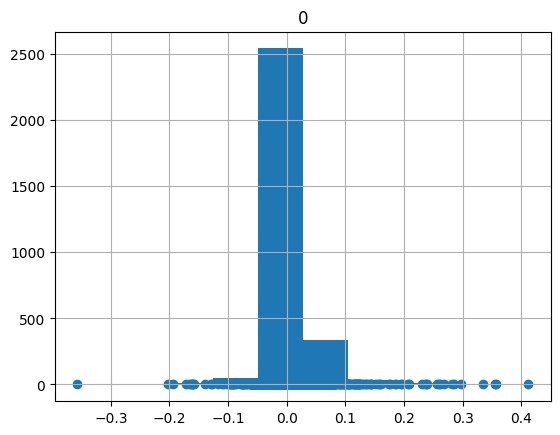

In [18]:
from matplotlib.pyplot import *
%matplotlib inline
plt.scatter(equivariance_noneq["all_output_orig"][0]["esp"], equivariance_noneq["all_output_trans"][0]["esp"])
plt.show()

In [19]:
# print("\n--- DCMNet (Equivariant) ---")
# equivariance_dcm = test_equivariance(
#     model_dcm,
#     params_dcm,
#     valid_data,
#     num_test_samples=args.equivariance_samples,
#     seed=args.seed,
# )

# print("\n--- Non-Equivariant ---")
# equivariance_noneq = test_equivariance(
#     model_noneq,
#     params_noneq,
#     valid_data,
#     num_test_samples=args.equivariance_samples,
#     seed=args.seed,
# )

In [20]:
from compare_models import predict_single

In [21]:
test_data.keys()

dict_keys(['R', 'Z', 'N', 'E', 'F', 'Dxyz', 'esp', 'vdw_surface'])

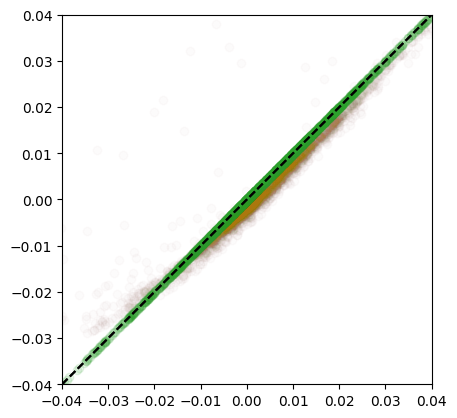

In [22]:
idx = 0
model = model_dcm
params = params_dcm
seed = 42
rng = np.random.RandomState(seed)
jax_key = jax.random.PRNGKey(seed)


R = test_data['R'][idx:idx+1]  # (1, natoms, 3)
Z = test_data['Z'][idx:idx+1]  # (1, natoms)
N = test_data['N'][idx:idx+1]  # (1,)
vdw_surface = test_data['vdw_surface'][idx:idx+1]  # (1, ngrid, 3)
TESTESP =  test_data['esp'][idx:idx+1]  # (1, ngrid, 3)
n_atoms = int(N[0])

graph = build_neighbor_graph(R, N)

# Original prediction
output_orig = predict_single(model, params, R, Z, N, vdw_surface, graph=graph)

# Test rotation
jax_key, rot_key, trans_key = jax.random.split(jax_key, 3)
rot_matrix = generate_random_rotation(rot_key)
R_rot = apply_rotation(R, rot_matrix)
vdw_rot = apply_rotation(vdw_surface, rot_matrix)

output_rot = predict_single(model, params, R_rot, Z, N, vdw_rot, graph=graph)

# For equivariant model: rotated output should equal rotation of original output
# Dipole should rotate
dipole_orig = jnp.asarray(output_orig['dipole'])
dipole_rot = jnp.asarray(output_rot['dipole'])
dipole_expected = jnp.einsum('ij,j->i', rot_matrix, dipole_orig)
rotation_error_dipole = jnp.linalg.norm(dipole_rot - dipole_expected)


# ESP should be identical at rotated grid points
esp_orig = jnp.asarray(output_orig['esp'])
esp_rot = jnp.asarray(output_rot['esp'])
rotation_error_esp = jnp.mean(jnp.abs(esp_rot - esp_orig))


# Test translation (both models should be translation invariant)
translation = 5.0 * jax.random.normal(trans_key, (3,), dtype=rot_matrix.dtype)
R_trans = apply_translation(R, translation)
vdw_trans = apply_translation(vdw_surface, translation)

output_trans = predict_single(model, params, R_trans, Z, N, vdw_trans, graph=graph)

# Dipole should be identical (molecule-centered)
dipole_trans = jnp.asarray(output_trans['dipole'])
translation_error_dipole = jnp.linalg.norm(dipole_trans - dipole_orig)


# ESP should be identical
esp_trans = jnp.asarray(output_trans['esp'])
translation_error_esp = jnp.mean(jnp.abs(esp_trans - esp_orig))


# Compare against reference quantities
true_energy = jnp.asarray(test_data['E'][idx])
energy_error = jnp.abs(jnp.asarray(output_orig['energy']) - true_energy)


true_dipole = jnp.asarray(test_data['Dxyz'][idx])
dipole_mae = jnp.mean(jnp.abs(dipole_orig - true_dipole))


true_forces = jnp.asarray(test_data['F'][idx])
if true_forces.ndim == 1:
    true_forces = true_forces.reshape(-1, 3)
forces_pred = jnp.asarray(output_orig['forces'])
forces_mae = jnp.mean(
    jnp.abs(forces_pred[:n_atoms] - true_forces[:n_atoms])
)
plt.scatter(output_orig['esp'], TESTESP, alpha=0.01)
for _ in [plt.ylim, plt.xlim]:
    _(-0.04, 0.04)
ax = plt.gca()
ax.set_aspect("equal")

plt.scatter(output_trans['esp'], TESTESP, alpha=0.01)
for _ in [plt.ylim, plt.xlim]:
    _(-0.04, 0.04)
ax = plt.gca()
ax.set_aspect("equal")
ax.plot([0,1],[0,1], transform=ax.transAxes, color="k", linestyle="--")


plt.scatter(output_orig['esp'], output_rot['esp'], alpha=0.1)
for _ in [plt.ylim, plt.xlim]:
    _(-0.04, 0.04)
ax = plt.gca()
ax.set_aspect("equal")

ax.plot([0,1],[0,1], transform=ax.transAxes, color="k", linestyle="--")

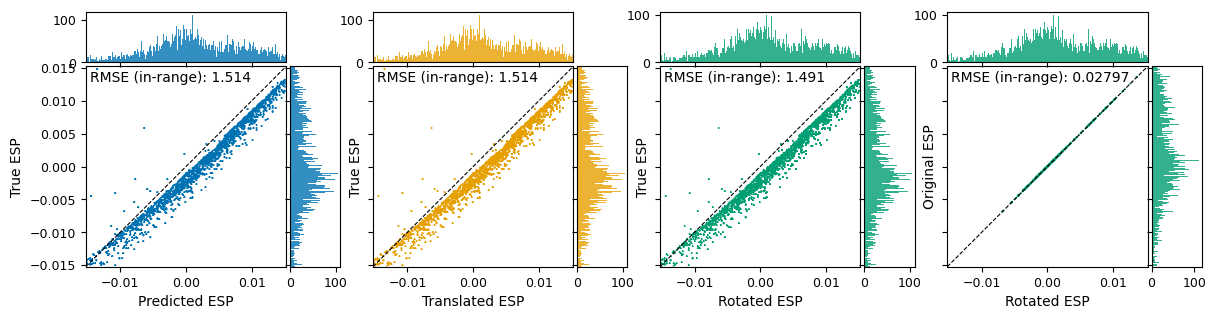

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# =========================
# CONFIG (no magic numbers)
# =========================
CFG = {
    "bounds_percentile": 75,            # symmetric axis limits from |values|
    "min_bins": 20,                       # FD lower clamp
    "max_bins": 200,                      # FD upper clamp
    "contour_percentiles": [70, 85, 93, 98],  # exactly 4 contour levels
    "line_width": 1.2,                    # contour line width
    "diag_width": 0.8,                    # diagonal line width
    "hist_alpha": 0.8,                    # marginal histogram alpha
    "hist_size_fraction": 0.25,           # tomography axes size as fraction of main axes
    "hist_pad_fraction": 0.02,            # padding as fraction of main axes
    "line_colors": {                      # Okabe–Ito-ish colors for lines
        "orig_vs_true":  "#0072B2",       # blue
        "trans_vs_true": "#E69F00",       # orange
        "rot_vs_orig":   "#009E73",       # green
    },
    "figsize": (12, 4.2),
    "title_size": 11,
    "label_size": 10,
    "tick_size": 9,
}

# =========================
# HELPERS
# =========================
def _finite(a):
    a = np.asarray(a).ravel()
    return a[np.isfinite(a)]

def _symmetric_limits(*arrays, p=99.5):
    vals = np.concatenate([_finite(a) for a in arrays]) if arrays else np.array([0.0])
    if vals.size == 0:
        return (-1.0, 1.0)
    L = np.nanpercentile(np.abs(vals), p)
    if not np.isfinite(L) or L == 0:
        L = np.max(np.abs(vals)) or 1.0
    return (-float(L), float(L))

def _fd_bins(x, min_bins, max_bins):
    x = _finite(x); n = x.size
    if n < 2:
        return min_bins
    q75, q25 = np.percentile(x, [75, 25])
    iqr = q75 - q25
    if iqr <= 0:
        bins = int(np.sqrt(max(n, 1)))
    else:
        h = 2 * iqr * n ** (-1/3)
        data_range = x.max() - x.min()
        bins = int(np.ceil(data_range / h)) if h > 0 else int(np.sqrt(max(n, 1)))
    return int(np.clip(bins, min_bins, max_bins))

def _hist2d_density(x, y, bins_x, bins_y, xlim, ylim):
    H, xedges, yedges = np.histogram2d(
        x, y, bins=[bins_x, bins_y], range=[xlim, ylim], density=True
    )
    return H.T, xedges, yedges

def _contour_levels_from_percentiles(density, percentiles):
    flat = density.ravel()
    flat = flat[(flat > 0) & np.isfinite(flat)]
    if flat.size == 0:
        # degenerate fallback
        return np.array([1e-12, 1e-10, 1e-8, 1e-6])
    levels = np.percentile(flat, percentiles)
    levels = np.unique(levels)
    if levels.size < 4:
        mn, mx = float(flat.min()), float(flat.max())
        if mx == mn:
            levels = mn * (1.0 + 1e-6 * np.arange(1, 5))
        else:
            levels = np.linspace(mn + 1e-12, mx, 4)
    return levels[:4]

def _rmse_in_limits(x, y, limits):
    x = _finite(x); y = _finite(y)
    m = (x >= limits[0]) & (x <= limits[1]) & (y >= limits[0]) & (y <= limits[1])
    if not np.any(m):
        return np.nan
    d = x[m] - y[m]
    return float(np.sqrt(np.mean(d * d)))

def plot_panel(ax_main, x, y, *, line_color, limits, cfg, title, xlabel, ylabel):
    """
    Unfilled 2D density contours (4 levels) + diagonal + marginal tomograms + RMSE annotation.
    """
    x = _finite(x); y = _finite(y)
    xlim = ylim = limits

    # Bins via FD
    bx = _fd_bins(x, cfg["min_bins"], cfg["max_bins"])
    by = _fd_bins(y, cfg["min_bins"], cfg["max_bins"])

    # Density grid
    H, xedges, yedges = _hist2d_density(x, y, bx, by, xlim, ylim)

    # Centers for contours
    Xc = 0.5 * (xedges[:-1] + xedges[1:])
    Yc = 0.5 * (yedges[:-1] + yedges[1:])
    X, Y = np.meshgrid(Xc, Yc)

    # Exactly 4 contour levels
    levels = _contour_levels_from_percentiles(H, cfg["contour_percentiles"])

    # Unfilled contour lines
    ax_main.contour(X, Y, H, levels=levels, colors=line_color, linewidths=cfg["line_width"])

    # Identity diagonal
    ax_main.plot([limits[0], limits[1]], [limits[0], limits[1]],
                 '--', color='k', linewidth=cfg["diag_width"])

    ax_main.set_xlim(limits); ax_main.set_ylim(limits); ax_main.set_aspect("equal")
    ax_main.set_title(title, fontsize=cfg["title_size"])
    ax_main.set_xlabel(xlabel, fontsize=cfg["label_size"])
    ax_main.set_ylabel(ylabel, fontsize=cfg["label_size"])
    ax_main.tick_params(labelsize=cfg["tick_size"])

    # RMSE (in-range)
    rmse = _rmse_in_limits(x, y, limits)
    ax_main.text(0.02, 0.98, f"RMSE (in-range): {rmse*627.5:.4g}",
                 transform=ax_main.transAxes, ha='left', va='top',
                 fontsize=cfg["label_size"])

    # ---- Tomography (marginal histograms) with FRACTION sizes ----
    divider = make_axes_locatable(ax_main)
    size_str = f"{cfg['hist_size_fraction']*100:.1f}%"   # e.g., "25.0%"
    pad_str  = f"{cfg['hist_pad_fraction']*100:.2f}%"

    ax_top   = divider.append_axes("top",  size=size_str, pad=pad_str, sharex=ax_main)
    ax_right = divider.append_axes("right", size=size_str, pad=pad_str, sharey=ax_main)

    # X projection
    bins_x = _fd_bins(x, cfg["min_bins"], cfg["max_bins"])
    ax_top.hist(x[(x>=limits[0]) & (x<=limits[1])], bins=bins_x, range=limits,
                color=line_color, alpha=cfg["hist_alpha"], density=True)
    ax_top.tick_params(labelbottom=False, labelsize=cfg["tick_size"])
    ax_top.set_xlim(limits)

    # Y projection
    bins_y = _fd_bins(y, cfg["min_bins"], cfg["max_bins"])
    ax_right.hist(y[(y>=limits[0]) & (y<=limits[1])], bins=bins_y, range=limits,
                  color=line_color, alpha=cfg["hist_alpha"], density=True, orientation='horizontal')
    ax_right.tick_params(labelleft=False, labelsize=cfg["tick_size"])
    ax_right.set_ylim(limits)

# =========================
# DATA EXTRACT (ESP arrays)
# =========================
esp_pred_orig  = np.asarray(output_orig['esp']).ravel()
esp_pred_rot   = np.asarray(output_rot['esp']).ravel()
esp_pred_trans = np.asarray(output_trans['esp']).ravel()
esp_true       = np.asarray(TESTESP).ravel()

# Shared robust symmetric limits across all panels
limits = _symmetric_limits(esp_pred_orig, esp_pred_rot, esp_pred_trans, esp_true,
                           p=CFG["bounds_percentile"])

# =========================
# PLOT (3 panels)
# =========================
fig, axes = plt.subplots(1, 4, figsize=CFG["figsize"], constrained_layout=True, sharex=True, sharey=True)

plot_panel(
    axes[0],
    esp_pred_orig, esp_true,
    line_color=CFG["line_colors"]["orig_vs_true"],
    limits=limits, cfg=CFG,
    title="Original vs True ESP",
    xlabel="Predicted ESP", ylabel="True ESP"
)

plot_panel(
    axes[1],
    esp_pred_trans, esp_true,
    line_color=CFG["line_colors"]["trans_vs_true"],
    limits=limits, cfg=CFG,
    title="Translated vs True ESP",
    xlabel="Translated ESP", ylabel="True ESP"
)

plot_panel(
    axes[2],
    esp_pred_rot, esp_true,
    line_color=CFG["line_colors"]["rot_vs_orig"],
    limits=limits, cfg=CFG,
    title="Rotated vs True ESP",
    xlabel="Rotated ESP", ylabel="True ESP"
)


plot_panel(
    axes[3],
    esp_pred_rot, esp_pred_orig,
    line_color=CFG["line_colors"]["rot_vs_orig"],
    limits=limits, cfg=CFG,
    title="Rotated vs Original ESP",
    xlabel="Rotated ESP", ylabel="Original ESP"
)

plt.show()


In [24]:
pd.DataFrame(TESTESP).T.describe()

,0
count,3000.000000
mean,0.011999
std,0.057131
min,-0.029080
25%,-0.004640
50%,0.000265
75%,0.009594
max,0.770380


In [25]:
np.sqrt(np.mean((output_trans['esp'] - TESTESP)**2)) * 627.5

np.float32(32.24309)

In [26]:
np.sqrt(np.mean((output_trans['esp'] - output_orig['esp'])**2)) * 627.5

np.float32(3.8468464e-05)

In [27]:
from compare_models import predict_single

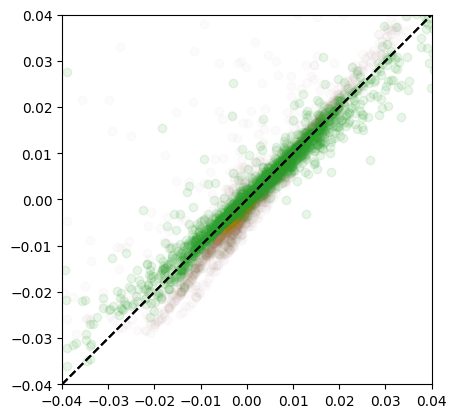

In [28]:
idx = 0
model = model_noneq
params = params_noneq
seed = 42
rng = np.random.RandomState(seed)
jax_key = jax.random.PRNGKey(seed)

R = test_data['R'][idx:idx+1]  # (1, natoms, 3)
Z = test_data['Z'][idx:idx+1]  # (1, natoms)
N = test_data['N'][idx:idx+1]  # (1,)
vdw_surface = test_data['vdw_surface'][idx:idx+1]  # (1, ngrid, 3)
TESTESP =  test_data['esp'][idx:idx+1]  # (1, ngrid, 3)
n_atoms = int(N[0])

graph = build_neighbor_graph(R, N)

# Original prediction
output_orig = predict_single(model, params, R, Z, N, vdw_surface, graph=graph)

# Test rotation
jax_key, rot_key, trans_key = jax.random.split(jax_key, 3)
rot_matrix = generate_random_rotation(rot_key)
R_rot = apply_rotation(R, rot_matrix)
vdw_rot = apply_rotation(vdw_surface, rot_matrix)

output_rot = predict_single(model, params, R_rot, Z, N, vdw_rot, graph=graph)

# For equivariant model: rotated output should equal rotation of original output
# Dipole should rotate
dipole_orig = jnp.asarray(output_orig['dipole'])
dipole_rot = jnp.asarray(output_rot['dipole'])
dipole_expected = jnp.einsum('ij,j->i', rot_matrix, dipole_orig)
rotation_error_dipole = jnp.linalg.norm(dipole_rot - dipole_expected)


# ESP should be identical at rotated grid points
esp_orig = jnp.asarray(output_orig['esp'])
esp_rot = jnp.asarray(output_rot['esp'])
rotation_error_esp = jnp.mean(jnp.abs(esp_rot - esp_orig))


# Test translation (both models should be translation invariant)
translation = 5.0 * jax.random.normal(trans_key, (3,), dtype=rot_matrix.dtype)
R_trans = apply_translation(R, translation)
vdw_trans = apply_translation(vdw_surface, translation)

output_trans = predict_single(model, params, R_trans, Z, N, vdw_trans, graph=graph)

# Dipole should be identical (molecule-centered)
dipole_trans = jnp.asarray(output_trans['dipole'])
translation_error_dipole = jnp.linalg.norm(dipole_trans - dipole_orig)


# ESP should be identical
esp_trans = jnp.asarray(output_trans['esp'])
translation_error_esp = jnp.mean(jnp.abs(esp_trans - esp_orig))


# Compare against reference quantities
true_energy = jnp.asarray(test_data['E'][idx])
energy_error = jnp.abs(jnp.asarray(output_orig['energy']) - true_energy)


true_dipole = jnp.asarray(test_data['Dxyz'][idx])
dipole_mae = jnp.mean(jnp.abs(dipole_orig - true_dipole))


true_forces = jnp.asarray(test_data['F'][idx])
if true_forces.ndim == 1:
    true_forces = true_forces.reshape(-1, 3)
forces_pred = jnp.asarray(output_orig['forces'])
forces_mae = jnp.mean(
    jnp.abs(forces_pred[:n_atoms] - true_forces[:n_atoms])
)
plt.scatter(output_orig['esp'], TESTESP, alpha=0.01)
for _ in [plt.ylim, plt.xlim]:
    _(-0.04, 0.04)
ax = plt.gca()
ax.set_aspect("equal")

plt.scatter(output_trans['esp'], TESTESP, alpha=0.01)
for _ in [plt.ylim, plt.xlim]:
    _(-0.04, 0.04)
ax = plt.gca()
ax.set_aspect("equal")
ax.plot([0,1],[0,1], transform=ax.transAxes, color="k", linestyle="--")

plt.scatter(output_orig['esp'], output_rot['esp'], alpha=0.1)
for _ in [plt.ylim, plt.xlim]:
    _(-0.04, 0.04)
ax = plt.gca()
ax.set_aspect("equal")

ax.plot([0,1],[0,1], transform=ax.transAxes, color="k", linestyle="--")

In [29]:
np.sqrt(np.mean((output_rot['esp'] - TESTESP)**2)) * 627.5

np.float32(32.54482)

In [30]:
np.sqrt(np.mean((output_trans['esp'] - output_orig['esp'])**2)) * 627.5

np.float32(1.0815712e-05)

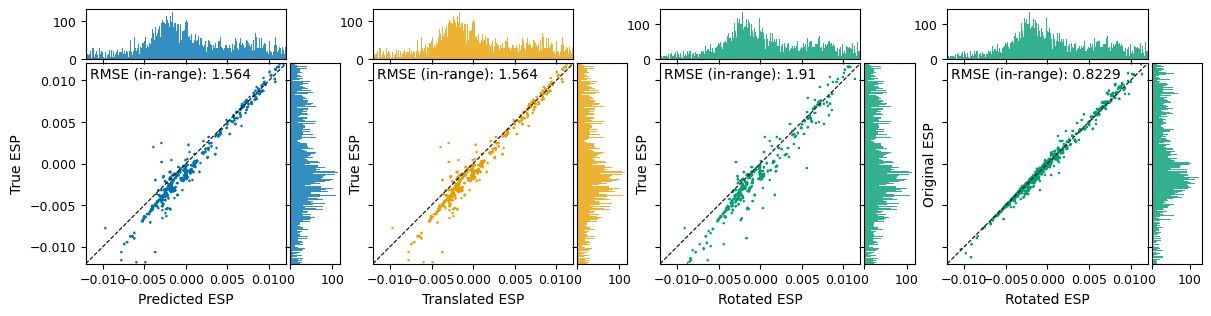

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# =========================
# CONFIG (no magic numbers)
# =========================
CFG = {
    "bounds_percentile": 75,            # symmetric axis limits from |values|
    "min_bins": 20,                       # FD lower clamp
    "max_bins": 200,                      # FD upper clamp
    "contour_percentiles": [70, 85, 93, 98],  # exactly 4 contour levels
    "line_width": 1.2,                    # contour line width
    "diag_width": 0.8,                    # diagonal line width
    "hist_alpha": 0.8,                    # marginal histogram alpha
    "hist_size_fraction": 0.25,           # tomography axes size as fraction of main axes
    "hist_pad_fraction": 0.02,            # padding as fraction of main axes
    "line_colors": {                      # Okabe–Ito-ish colors for lines
        "orig_vs_true":  "#0072B2",       # blue
        "trans_vs_true": "#E69F00",       # orange
        "rot_vs_orig":   "#009E73",       # green
    },
    "figsize": (12, 4.2),
    "title_size": 11,
    "label_size": 10,
    "tick_size": 9,
}

# =========================
# HELPERS
# =========================
def _finite(a):
    a = np.asarray(a).ravel()
    return a[np.isfinite(a)]

def _symmetric_limits(*arrays, p=99.5):
    vals = np.concatenate([_finite(a) for a in arrays]) if arrays else np.array([0.0])
    if vals.size == 0:
        return (-1.0, 1.0)
    L = np.nanpercentile(np.abs(vals), p)
    if not np.isfinite(L) or L == 0:
        L = np.max(np.abs(vals)) or 1.0
    return (-float(L), float(L))

def _fd_bins(x, min_bins, max_bins):
    x = _finite(x); n = x.size
    if n < 2:
        return min_bins
    q75, q25 = np.percentile(x, [75, 25])
    iqr = q75 - q25
    if iqr <= 0:
        bins = int(np.sqrt(max(n, 1)))
    else:
        h = 2 * iqr * n ** (-1/3)
        data_range = x.max() - x.min()
        bins = int(np.ceil(data_range / h)) if h > 0 else int(np.sqrt(max(n, 1)))
    return int(np.clip(bins, min_bins, max_bins))

def _hist2d_density(x, y, bins_x, bins_y, xlim, ylim):
    H, xedges, yedges = np.histogram2d(
        x, y, bins=[bins_x, bins_y], range=[xlim, ylim], density=True
    )
    return H.T, xedges, yedges

def _contour_levels_from_percentiles(density, percentiles):
    flat = density.ravel()
    flat = flat[(flat > 0) & np.isfinite(flat)]
    if flat.size == 0:
        # degenerate fallback
        return np.array([1e-12, 1e-10, 1e-8, 1e-6])
    levels = np.percentile(flat, percentiles)
    levels = np.unique(levels)
    if levels.size < 4:
        mn, mx = float(flat.min()), float(flat.max())
        if mx == mn:
            levels = mn * (1.0 + 1e-6 * np.arange(1, 5))
        else:
            levels = np.linspace(mn + 1e-12, mx, 4)
    return levels[:4]

def _rmse_in_limits(x, y, limits):
    x = _finite(x); y = _finite(y)
    m = (x >= limits[0]) & (x <= limits[1]) & (y >= limits[0]) & (y <= limits[1])
    if not np.any(m):
        return np.nan
    d = x[m] - y[m]
    return float(np.sqrt(np.mean(d * d)))

def plot_panel(ax_main, x, y, *, line_color, limits, cfg, title, xlabel, ylabel):
    """
    Unfilled 2D density contours (4 levels) + diagonal + marginal tomograms + RMSE annotation.
    """
    x = _finite(x); y = _finite(y)
    xlim = ylim = limits

    # Bins via FD
    bx = _fd_bins(x, cfg["min_bins"], cfg["max_bins"])
    by = _fd_bins(y, cfg["min_bins"], cfg["max_bins"])

    # Density grid
    H, xedges, yedges = _hist2d_density(x, y, bx, by, xlim, ylim)

    # Centers for contours
    Xc = 0.5 * (xedges[:-1] + xedges[1:])
    Yc = 0.5 * (yedges[:-1] + yedges[1:])
    X, Y = np.meshgrid(Xc, Yc)

    # Exactly 4 contour levels
    levels = _contour_levels_from_percentiles(H, cfg["contour_percentiles"])

    # Unfilled contour lines
    ax_main.contour(X, Y, H, levels=levels, colors=line_color, linewidths=cfg["line_width"])

    # Identity diagonal
    ax_main.plot([limits[0], limits[1]], [limits[0], limits[1]],
                 '--', color='k', linewidth=cfg["diag_width"])

    ax_main.set_xlim(limits); ax_main.set_ylim(limits); ax_main.set_aspect("equal")
    ax_main.set_title(title, fontsize=cfg["title_size"])
    ax_main.set_xlabel(xlabel, fontsize=cfg["label_size"])
    ax_main.set_ylabel(ylabel, fontsize=cfg["label_size"])
    ax_main.tick_params(labelsize=cfg["tick_size"])

    # RMSE (in-range)
    rmse = _rmse_in_limits(x, y, limits)
    ax_main.text(0.02, 0.98, f"RMSE (in-range): {rmse*627.5:.4g}",
                 transform=ax_main.transAxes, ha='left', va='top',
                 fontsize=cfg["label_size"])

    # ---- Tomography (marginal histograms) with FRACTION sizes ----
    divider = make_axes_locatable(ax_main)
    size_str = f"{cfg['hist_size_fraction']*100:.1f}%"   # e.g., "25.0%"
    pad_str  = f"{cfg['hist_pad_fraction']*100:.2f}%"

    ax_top   = divider.append_axes("top",  size=size_str, pad=pad_str, sharex=ax_main)
    ax_right = divider.append_axes("right", size=size_str, pad=pad_str, sharey=ax_main)

    # X projection
    bins_x = _fd_bins(x, cfg["min_bins"], cfg["max_bins"])
    ax_top.hist(x[(x>=limits[0]) & (x<=limits[1])], bins=bins_x, range=limits,
                color=line_color, alpha=cfg["hist_alpha"], density=True)
    ax_top.tick_params(labelbottom=False, labelsize=cfg["tick_size"])
    ax_top.set_xlim(limits)

    # Y projection
    bins_y = _fd_bins(y, cfg["min_bins"], cfg["max_bins"])
    ax_right.hist(y[(y>=limits[0]) & (y<=limits[1])], bins=bins_y, range=limits,
                  color=line_color, alpha=cfg["hist_alpha"], density=True, orientation='horizontal')
    ax_right.tick_params(labelleft=False, labelsize=cfg["tick_size"])
    ax_right.set_ylim(limits)

# =========================
# DATA EXTRACT (ESP arrays)
# =========================
esp_pred_orig  = np.asarray(output_orig['esp']).ravel()
esp_pred_rot   = np.asarray(output_rot['esp']).ravel()
esp_pred_trans = np.asarray(output_trans['esp']).ravel()
esp_true       = np.asarray(TESTESP).ravel()

# Shared robust symmetric limits across all panels
limits = _symmetric_limits(esp_pred_orig, esp_pred_rot, esp_pred_trans, esp_true,
                           p=CFG["bounds_percentile"])

# =========================
# PLOT (3 panels)
# =========================
fig, axes = plt.subplots(1, 4, figsize=CFG["figsize"], constrained_layout=True, sharex=True, sharey=True)

plot_panel(
    axes[0],
    esp_pred_orig, esp_true,
    line_color=CFG["line_colors"]["orig_vs_true"],
    limits=limits, cfg=CFG,
    title="Original vs True ESP",
    xlabel="Predicted ESP", ylabel="True ESP"
)

plot_panel(
    axes[1],
    esp_pred_trans, esp_true,
    line_color=CFG["line_colors"]["trans_vs_true"],
    limits=limits, cfg=CFG,
    title="Translated vs True ESP",
    xlabel="Translated ESP", ylabel="True ESP"
)

plot_panel(
    axes[2],
    esp_pred_rot, esp_true,
    line_color=CFG["line_colors"]["rot_vs_orig"],
    limits=limits, cfg=CFG,
    title="Rotated vs True ESP",
    xlabel="Rotated ESP", ylabel="True ESP"
)


plot_panel(
    axes[3],
    esp_pred_rot, esp_pred_orig,
    line_color=CFG["line_colors"]["rot_vs_orig"],
    limits=limits, cfg=CFG,
    title="Rotated vs Original ESP",
    xlabel="Rotated ESP", ylabel="Original ESP"
)

plt.show()


In [6]:
import numpy as np

initial_positions = np.array([
    [0.0, 0.0, 0.0],      # C
    [0.0, 0.0, 1.16],     # O
    [0.0, 0.0, -1.16],    # O
])
atomic_numbers = np.array([6, 8, 8])

# Target number of atoms
n_target = 60

# --- Pad positions (shape: (60, 3)) ---
padded_positions = np.zeros((n_target, 3))
padded_positions[:initial_positions.shape[0], :] = initial_positions

# --- Pad atomic numbers (shape: (60,)) ---
padded_atomic_numbers = np.zeros(n_target, dtype=int)
padded_atomic_numbers[:atomic_numbers.shape[0]] = atomic_numbers

print(padded_positions.shape, padded_atomic_numbers.shape)

from jaxmd_dynamics import *
from trainer import JointPhysNetDCMNet
from jax_md import space, partition, simulate

import jax
import jax.numpy as jnp
from jax import random, jit, grad, vmap
import flax.linen as nn


idx = 0
model = model_noneq
params = params_noneq
seed = 42
rng = np.random.RandomState(seed)
jax_key = jax.random.PRNGKey(seed)

(60, 3) (60,)


NameError: name 'np' is not defined

In [7]:
dcm_ckpt_dir = output_dir / 'dcmnet_equivariant'

In [9]:
dcm_ckpt_dir.resolve()

PosixPath('/scicore/home/meuwly/boitti0000/mmml/examples/co2/dcmnet_physnet_train/comparisons/interactive_comparison3/dcmnet_equivariant')

In [126]:
model

JointPhysNetNonEquivariant(
    # attributes
    physnet_config = {'features': 128, 'max_degree': 0, 'num_iterations': 3, 'num_basis_functions': 64, 'cutoff': 6.0, 'max_atomic_number': 8, 'charges': True, 'natoms': 60, 'total_charge': 0.0, 'n_res': 3, 'zbl': False, 'use_energy_bias': True, 'debug': False, 'efa': False}
    noneq_config = {'features': 256, 'n_dcm': 2, 'max_atomic_number': 8, 'num_layers': 5, 'max_displacement': 1.0}
    mix_coulomb_energy = False
    mixer_config = None
)

In [127]:
def create_model_energy_fn(model, params, atomic_numbers_static, cutoff=10.0):
    atomic_numbers_static = jnp.asarray(atomic_numbers_static)

    @jax.jit
    def energy_fn(positions, neighbor):
        dst_idx = neighbor.idx[0]
        src_idx = neighbor.idx[1]
        edge_mask = (dst_idx >= 0).astype(jnp.float32)

        dst_idx = jnp.where(edge_mask > 0, dst_idx, 0)
        src_idx = jnp.where(edge_mask > 0, src_idx, 0)

        n_atoms = atomic_numbers_static.size
        batch_segments = jnp.zeros(n_atoms, dtype=jnp.int32)
        atom_mask = jnp.ones(n_atoms, dtype=jnp.float32)

        output = model.apply(
            params,
            atomic_numbers=atomic_numbers_static,
            positions=positions,
            dst_idx=dst_idx,
            src_idx=src_idx,
            batch_segments=batch_segments,
            batch_size=1,
            batch_mask=edge_mask,
            atom_mask=atom_mask,
        )
        return output['energy'][0], output['forces']

    return energy_fn

In [128]:
energy_fn = create_model_energy_fn(model, params, atomic_numbers, cutoff)
init_fn, apply_fn = simulate.nvt_nose_hoover(energy_fn, shift, dt, kT)


In [129]:
cutoff = 10

In [130]:
initialize_system

<function jaxmd_dynamics.initialize_system(molecule='CO2', temperature=300.0, box_size=50.0)>

In [131]:
_, _, masses, box = initialize_system(molecule='CO2', temperature=300.0, box_size=50.0)

In [132]:


energy_fn = create_model_energy_fn(model, params, atomic_numbers)
displacement, shift = space.free()

nbrs = neighbor_fn.allocate(initial_positions)

In [133]:
# neighbor_fn = partition.neighbor_list(displacement, 1000, cutoff/2, format=partition.Sparse)

In [134]:
temperature = 100
key = random.PRNGKey(seed)
dt = 0.5  # fs
kT = 8.617e-5 * temperature
init_fn, apply_fn = simulate.nvt_nose_hoover(energy_fn, shift, dt, kT)
state = init_fn(key, initial_positions, masses, neighbor=nbrs)

for step in range(num_steps):
    state, nbrs = simulate.step(state, nbrs)   # see jaxmd_dynamics.py for full loop

ValueError: Incompatible shapes for broadcasting: (60,) and requested shape (3,)

In [103]:
import jax
import jax.numpy as jnp
import numpy as np
from jax_md import space, simulate

# -----------------------------------------------------------------------------
# Single-copy helpers
# -----------------------------------------------------------------------------

def build_single_graph(positions_single, cutoff, model_natoms):
    """Dense edge list inside cutoff, padded to model_natoms."""
    n_true = positions_single.shape[0]
    dst_list, src_list = [], []
    for i in range(n_true):
        for j in range(n_true):
            if i != j and np.linalg.norm(positions_single[i] - positions_single[j]) < cutoff:
                dst_list.append(i)
                src_list.append(j)
    n_edges = len(dst_list)
    if n_edges == 0:
        raise ValueError("No edges within cutoff; increase cutoff or check geometry.")
    dst = jnp.zeros((model_natoms,), dtype=jnp.int32).at[:n_edges].set(jnp.asarray(dst_list))
    src = jnp.zeros((model_natoms,), dtype=jnp.int32).at[:n_edges].set(jnp.asarray(src_list))
    edge_mask = jnp.zeros((model_natoms,), dtype=jnp.float32).at[:n_edges].set(1.0)
    return dst, src, edge_mask, n_edges


def initialize_velocities_single(key, masses_single, temperature):
    """Maxwell–Boltzmann velocities for one molecule."""
    kB = 8.617333262e-5  # eV/K
    sigma = jnp.sqrt(kB * temperature / (masses_single[:, None] * 0.01036427))
    v = jax.random.normal(key, shape=sigma.shape) * sigma
    v = v - jnp.mean(v, axis=0, keepdims=True)
    return v

# -----------------------------------------------------------------------------
# Batched (multi-copy) helpers
# -----------------------------------------------------------------------------

def pack_replicas(positions_single, atomic_numbers_single, masses_single,
                  model_natoms, B, translation):
    n_true = positions_single.shape[0]
    natoms_total = B * model_natoms

    positions = jnp.zeros((natoms_total, 3), dtype=jnp.float32)
    atomic_numbers = jnp.zeros((natoms_total,), dtype=jnp.int32)
    atom_mask = jnp.zeros((natoms_total,), dtype=jnp.float32)
    masses = jnp.zeros((natoms_total,), dtype=jnp.float32)
    batch_segments = jnp.repeat(jnp.arange(B, dtype=jnp.int32), model_natoms)

    positions_single = jnp.asarray(positions_single, dtype=jnp.float32)
    atomic_numbers_single = jnp.asarray(atomic_numbers_single, dtype=jnp.int32)
    masses_single = jnp.asarray(masses_single, dtype=jnp.float32)

    pad_mass = jnp.pad(masses_single, (0, model_natoms - n_true))

    offsets = translation * jnp.arange(B, dtype=jnp.float32)[:, None] * jnp.array([1., 0., 0.])

    for k in range(B):
        start = k * model_natoms
        end = start + model_natoms

        pos_block = jnp.zeros((model_natoms, 3), dtype=jnp.float32)
        pos_block = pos_block.at[:n_true].set(positions_single + offsets[k])
        positions = positions.at[start:end].set(pos_block)

        Z_block = jnp.zeros((model_natoms,), dtype=jnp.int32)
        Z_block = Z_block.at[:n_true].set(atomic_numbers_single)
        atomic_numbers = atomic_numbers.at[start:end].set(Z_block)

        mask_block = jnp.zeros((model_natoms,), dtype=jnp.float32).at[:n_true].set(1.0)
        atom_mask = atom_mask.at[start:end].set(mask_block)

        masses = masses.at[start:end].set(pad_mass)

    return positions, atomic_numbers, atom_mask, masses, batch_segments


def build_batched_graph(dst_single, src_single, edge_mask_single,
                        model_natoms, B, edges_per_single):
    offsets = jnp.arange(B, dtype=jnp.int32) * model_natoms
    dst = jnp.concatenate([dst_single[:edges_per_single] + off for off in offsets])
    src = jnp.concatenate([src_single[:edges_per_single] + off for off in offsets])
    edge_mask = jnp.tile(edge_mask_single[:edges_per_single], B)
    return dst, src, edge_mask


def initialize_velocities_multi(key, masses, atom_mask, model_natoms, B, temperature):
    kB = 8.617333262e-5
    sigma = jnp.sqrt(kB * temperature / (masses[:, None] * 0.01036427))
    v = jax.random.normal(key, shape=sigma.shape) * sigma
    v = v * atom_mask[:, None]
    v = v.reshape(B, model_natoms, 3)
    v = v - jnp.mean(v, axis=1, keepdims=True)
    return v.reshape(-1, 3)


def create_multi_energy_fn(model, params,
                           atomic_numbers, atom_mask,
                           dst_idx, src_idx, edge_mask,
                           batch_segments, model_natoms, B):
    natoms_total = atomic_numbers.shape[0]

    @jax.jit
    def energy_fn(positions, *_):
        output = model.apply(
            params,
            atomic_numbers=atomic_numbers,
            positions=positions,
            dst_idx=dst_idx,
            src_idx=src_idx,
            batch_segments=batch_segments,
            batch_size=B,
            batch_mask=edge_mask,
            atom_mask=atom_mask,
        )
        energies = output['energy'][:B]
        forces = output['forces'][:natoms_total]
        return jnp.sum(energies), forces

    return energy_fn

# -----------------------------------------------------------------------------
# Main driver
# -----------------------------------------------------------------------------

def run_multi_copy_dynamics(model, params,
                            positions_single, atomic_numbers_single, masses_single,
                            B=8, dt=0.5, temperature=300.0,
                            cutoff=10.0, steps=10000, translation=25.0, key_seed=0):
    model_natoms = model.physnet_config['natoms']

    positions_packed, Z_packed, atom_mask, masses_packed, batch_segments = pack_replicas(
        positions_single, atomic_numbers_single, masses_single,
        model_natoms, B, translation
    )

    dst_single, src_single, edge_mask_single, edges_per_single = build_single_graph(
        np.asarray(positions_single), cutoff, model_natoms
    )
    dst_idx, src_idx, edge_mask = build_batched_graph(
        dst_single, src_single, edge_mask_single, model_natoms, B, edges_per_single
    )
    edge_mask = edge_mask.astype(jnp.float32)

    energy_fn = create_multi_energy_fn(
        model, params, Z_packed, atom_mask,
        dst_idx, src_idx, edge_mask, batch_segments,
        model_natoms, B,
    )

    displacement, shift = space.free()
    init_fn, step_fn = simulate.nvt_nose_hoover(energy_fn, shift, dt, 8.617e-5 * temperature)

    key = jax.random.PRNGKey(key_seed)
    velocities = initialize_velocities_multi(
        key, masses_packed, atom_mask, model_natoms, B, temperature
    )
    state = init_fn(key, positions_packed, masses_packed, velocity=velocities)

    traj = []
    for _ in range(steps):
        state = step_fn(state)
        traj.append(state.position.reshape(B, model_natoms, 3))

    traj = np.asarray(traj)[:, :, :positions_single.shape[0], :]
    return traj, state

In [105]:
positions_single, atomic_numbers_single, masses_single, _ = initialize_system('CO2')
traj, state = run_multi_copy_dynamics(
    model, params,
    positions_single,
    atomic_numbers_single,
    masses_single,
    B=16,
    dt=0.5,
    temperature=300.0,
    cutoff=10.0,
    steps=20000,
    translation=30.0,
    key_seed=0,
)

TypeError: cannot reshape array of shape (960, 1) (size 960) into shape (16, 60, 3) (size 2880)

In [32]:
0.002085 * 0627.5

1.3083375

In [33]:
# all_output_orig

In [34]:
0.013442525267601013 * 627.5

8.435184605419636

In [35]:
equivariance_dcm.keys()

dict_keys(['rotation_error_dipole', 'rotation_error_esp', 'translation_error_dipole', 'translation_error_esp', 'rotation_error_dipole_std', 'rotation_error_esp_std', 'translation_error_dipole_std', 'translation_error_esp_std', 'energy_mae', 'forces_mae', 'dipole_mae', 'esp_mae', 'energy_mae_std', 'forces_mae_std', 'dipole_mae_std', 'esp_mae_std', 'all_output_orig', 'all_output_rot', 'all_output_trans'])

In [36]:
equivariance_dcm["all_output_orig"][0].keys()

dict_keys(['dipole', 'esp', 'esp_points', 'energy', 'forces'])

In [37]:
# plt.hist()


In [38]:
pd.DataFrame(equivariance_noneq["all_output_orig"][0]["esp"]).describe()

,0
count,3000.000000
mean,0.005288
std,0.037005
min,-0.357059
25%,-0.008853
50%,-0.002210
75%,0.014751
max,0.411965


array([[<Axes: title={'center': '0'}>]], dtype=object)

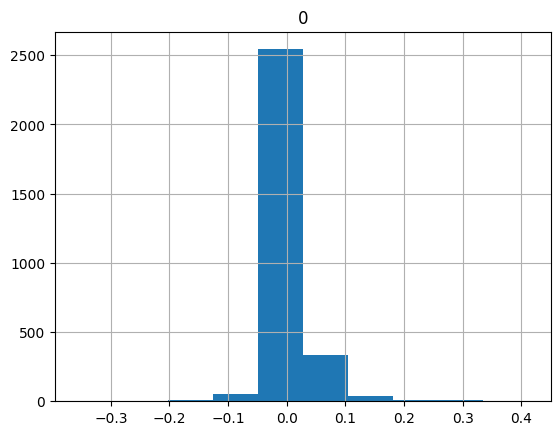

In [39]:
pd.DataFrame(equivariance_noneq["all_output_trans"][0]["esp"]).hist()

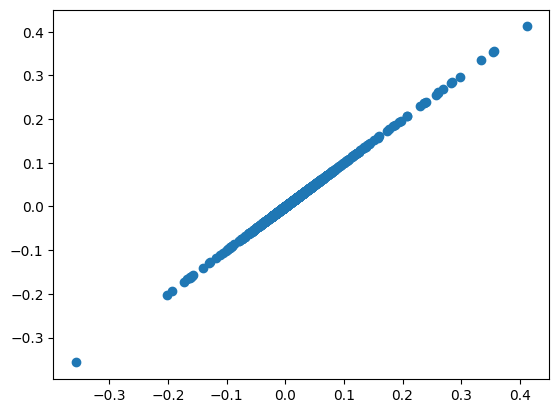

In [40]:
from matplotlib.pyplot import *
%matplotlib inline
plt.scatter(equivariance_noneq["all_output_orig"][0]["esp"], equivariance_noneq["all_output_trans"][0]["esp"])
plt.show()

In [41]:
# print("\n--- DCMNet (Equivariant) ---")
# equivariance_dcm = test_equivariance(
#     model_dcm,
#     params_dcm,
#     valid_data,
#     num_test_samples=args.equivariance_samples,
#     seed=args.seed,
# )

# print("\n--- Non-Equivariant ---")
# equivariance_noneq = test_equivariance(
#     model_noneq,
#     params_noneq,
#     valid_data,
#     num_test_samples=args.equivariance_samples,
#     seed=args.seed,
# )

In [42]:
from compare_models import predict_single

In [43]:
test_data.keys()

dict_keys(['R', 'Z', 'N', 'E', 'F', 'Dxyz', 'esp', 'vdw_surface'])

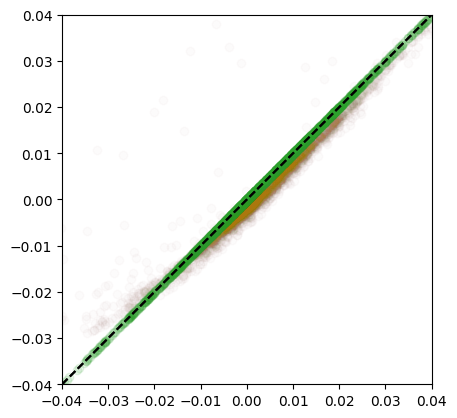

In [44]:
idx = 0
model = model_dcm
params = params_dcm
seed = 42
rng = np.random.RandomState(seed)
jax_key = jax.random.PRNGKey(seed)


R = test_data['R'][idx:idx+1]  # (1, natoms, 3)
Z = test_data['Z'][idx:idx+1]  # (1, natoms)
N = test_data['N'][idx:idx+1]  # (1,)
vdw_surface = test_data['vdw_surface'][idx:idx+1]  # (1, ngrid, 3)
TESTESP =  test_data['esp'][idx:idx+1]  # (1, ngrid, 3)
n_atoms = int(N[0])

graph = build_neighbor_graph(R, N)

# Original prediction
output_orig = predict_single(model, params, R, Z, N, vdw_surface, graph=graph)

# Test rotation
jax_key, rot_key, trans_key = jax.random.split(jax_key, 3)
rot_matrix = generate_random_rotation(rot_key)
R_rot = apply_rotation(R, rot_matrix)
vdw_rot = apply_rotation(vdw_surface, rot_matrix)

output_rot = predict_single(model, params, R_rot, Z, N, vdw_rot, graph=graph)

# For equivariant model: rotated output should equal rotation of original output
# Dipole should rotate
dipole_orig = jnp.asarray(output_orig['dipole'])
dipole_rot = jnp.asarray(output_rot['dipole'])
dipole_expected = jnp.einsum('ij,j->i', rot_matrix, dipole_orig)
rotation_error_dipole = jnp.linalg.norm(dipole_rot - dipole_expected)


# ESP should be identical at rotated grid points
esp_orig = jnp.asarray(output_orig['esp'])
esp_rot = jnp.asarray(output_rot['esp'])
rotation_error_esp = jnp.mean(jnp.abs(esp_rot - esp_orig))


# Test translation (both models should be translation invariant)
translation = 5.0 * jax.random.normal(trans_key, (3,), dtype=rot_matrix.dtype)
R_trans = apply_translation(R, translation)
vdw_trans = apply_translation(vdw_surface, translation)

output_trans = predict_single(model, params, R_trans, Z, N, vdw_trans, graph=graph)

# Dipole should be identical (molecule-centered)
dipole_trans = jnp.asarray(output_trans['dipole'])
translation_error_dipole = jnp.linalg.norm(dipole_trans - dipole_orig)


# ESP should be identical
esp_trans = jnp.asarray(output_trans['esp'])
translation_error_esp = jnp.mean(jnp.abs(esp_trans - esp_orig))


# Compare against reference quantities
true_energy = jnp.asarray(test_data['E'][idx])
energy_error = jnp.abs(jnp.asarray(output_orig['energy']) - true_energy)


true_dipole = jnp.asarray(test_data['Dxyz'][idx])
dipole_mae = jnp.mean(jnp.abs(dipole_orig - true_dipole))


true_forces = jnp.asarray(test_data['F'][idx])
if true_forces.ndim == 1:
    true_forces = true_forces.reshape(-1, 3)
forces_pred = jnp.asarray(output_orig['forces'])
forces_mae = jnp.mean(
    jnp.abs(forces_pred[:n_atoms] - true_forces[:n_atoms])
)
plt.scatter(output_orig['esp'], TESTESP, alpha=0.01)
for _ in [plt.ylim, plt.xlim]:
    _(-0.04, 0.04)
ax = plt.gca()
ax.set_aspect("equal")

plt.scatter(output_trans['esp'], TESTESP, alpha=0.01)
for _ in [plt.ylim, plt.xlim]:
    _(-0.04, 0.04)
ax = plt.gca()
ax.set_aspect("equal")
ax.plot([0,1],[0,1], transform=ax.transAxes, color="k", linestyle="--")


plt.scatter(output_orig['esp'], output_rot['esp'], alpha=0.1)
for _ in [plt.ylim, plt.xlim]:
    _(-0.04, 0.04)
ax = plt.gca()
ax.set_aspect("equal")

ax.plot([0,1],[0,1], transform=ax.transAxes, color="k", linestyle="--")

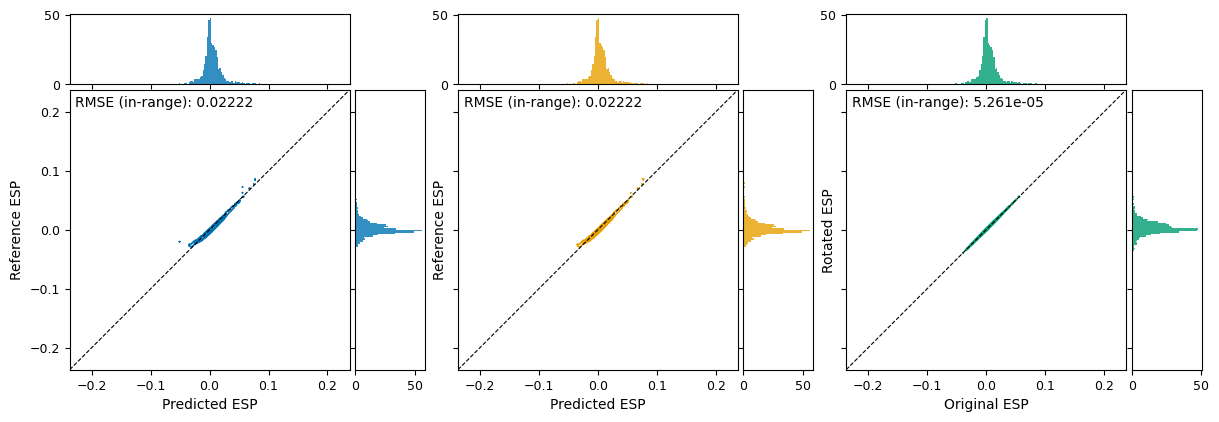

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# =========================
# CONFIG (no magic numbers)
# =========================
CFG = {
    "bounds_percentile": 99.5,            # symmetric axis limits from |values|
    "min_bins": 20,                       # FD lower clamp
    "max_bins": 200,                      # FD upper clamp
    "contour_percentiles": [70, 85, 93, 98],  # exactly 4 contour levels
    "line_width": 1.2,                    # contour line width
    "diag_width": 0.8,                    # diagonal line width
    "hist_alpha": 0.8,                    # marginal histogram alpha
    "hist_size_fraction": 0.25,           # tomography axes size as fraction of main axes
    "hist_pad_fraction": 0.02,            # padding as fraction of main axes
    "line_colors": {                      # Okabe–Ito-ish colors for lines
        "orig_vs_true":  "#0072B2",       # blue
        "trans_vs_true": "#E69F00",       # orange
        "rot_vs_orig":   "#009E73",       # green
    },
    "figsize": (12, 4.2),
    "title_size": 11,
    "label_size": 10,
    "tick_size": 9,
}

# =========================
# HELPERS
# =========================
def _finite(a):
    a = np.asarray(a).ravel()
    return a[np.isfinite(a)]

def _symmetric_limits(*arrays, p=99.5):
    vals = np.concatenate([_finite(a) for a in arrays]) if arrays else np.array([0.0])
    if vals.size == 0:
        return (-1.0, 1.0)
    L = np.nanpercentile(np.abs(vals), p)
    if not np.isfinite(L) or L == 0:
        L = np.max(np.abs(vals)) or 1.0
    return (-float(L), float(L))

def _fd_bins(x, min_bins, max_bins):
    x = _finite(x); n = x.size
    if n < 2:
        return min_bins
    q75, q25 = np.percentile(x, [75, 25])
    iqr = q75 - q25
    if iqr <= 0:
        bins = int(np.sqrt(max(n, 1)))
    else:
        h = 2 * iqr * n ** (-1/3)
        data_range = x.max() - x.min()
        bins = int(np.ceil(data_range / h)) if h > 0 else int(np.sqrt(max(n, 1)))
    return int(np.clip(bins, min_bins, max_bins))

def _hist2d_density(x, y, bins_x, bins_y, xlim, ylim):
    H, xedges, yedges = np.histogram2d(
        x, y, bins=[bins_x, bins_y], range=[xlim, ylim], density=True
    )
    return H.T, xedges, yedges

def _contour_levels_from_percentiles(density, percentiles):
    flat = density.ravel()
    flat = flat[(flat > 0) & np.isfinite(flat)]
    if flat.size == 0:
        # degenerate fallback
        return np.array([1e-12, 1e-10, 1e-8, 1e-6])
    levels = np.percentile(flat, percentiles)
    levels = np.unique(levels)
    if levels.size < 4:
        mn, mx = float(flat.min()), float(flat.max())
        if mx == mn:
            levels = mn * (1.0 + 1e-6 * np.arange(1, 5))
        else:
            levels = np.linspace(mn + 1e-12, mx, 4)
    return levels[:4]

def _rmse_in_limits(x, y, limits):
    x = _finite(x); y = _finite(y)
    m = (x >= limits[0]) & (x <= limits[1]) & (y >= limits[0]) & (y <= limits[1])
    if not np.any(m):
        return np.nan
    d = x[m] - y[m]
    return float(np.sqrt(np.mean(d * d)))

def plot_panel(ax_main, x, y, *, line_color, limits, cfg, title, xlabel, ylabel):
    """
    Unfilled 2D density contours (4 levels) + diagonal + marginal tomograms + RMSE annotation.
    """
    x = _finite(x); y = _finite(y)
    xlim = ylim = limits

    # Bins via FD
    bx = _fd_bins(x, cfg["min_bins"], cfg["max_bins"])
    by = _fd_bins(y, cfg["min_bins"], cfg["max_bins"])

    # Density grid
    H, xedges, yedges = _hist2d_density(x, y, bx, by, xlim, ylim)

    # Centers for contours
    Xc = 0.5 * (xedges[:-1] + xedges[1:])
    Yc = 0.5 * (yedges[:-1] + yedges[1:])
    X, Y = np.meshgrid(Xc, Yc)

    # Exactly 4 contour levels
    levels = _contour_levels_from_percentiles(H, cfg["contour_percentiles"])

    # Unfilled contour lines
    ax_main.contour(X, Y, H, levels=levels, colors=line_color, linewidths=cfg["line_width"])

    # Identity diagonal
    ax_main.plot([limits[0], limits[1]], [limits[0], limits[1]],
                 '--', color='k', linewidth=cfg["diag_width"])

    ax_main.set_xlim(limits); ax_main.set_ylim(limits); ax_main.set_aspect("equal")
    ax_main.set_title(title, fontsize=cfg["title_size"])
    ax_main.set_xlabel(xlabel, fontsize=cfg["label_size"])
    ax_main.set_ylabel(ylabel, fontsize=cfg["label_size"])
    ax_main.tick_params(labelsize=cfg["tick_size"])

    # RMSE (in-range)
    rmse = _rmse_in_limits(x, y, limits)
    ax_main.text(0.02, 0.98, f"RMSE (in-range): {rmse:.4g}",
                 transform=ax_main.transAxes, ha='left', va='top',
                 fontsize=cfg["label_size"])

    # ---- Tomography (marginal histograms) with FRACTION sizes ----
    divider = make_axes_locatable(ax_main)
    size_str = f"{cfg['hist_size_fraction']*100:.1f}%"   # e.g., "25.0%"
    pad_str  = f"{cfg['hist_pad_fraction']*100:.2f}%"

    ax_top   = divider.append_axes("top",  size=size_str, pad=pad_str, sharex=ax_main)
    ax_right = divider.append_axes("right", size=size_str, pad=pad_str, sharey=ax_main)

    # X projection
    bins_x = _fd_bins(x, cfg["min_bins"], cfg["max_bins"])
    ax_top.hist(x[(x>=limits[0]) & (x<=limits[1])], bins=bins_x, range=limits,
                color=line_color, alpha=cfg["hist_alpha"], density=True)
    ax_top.tick_params(labelbottom=False, labelsize=cfg["tick_size"])
    ax_top.set_xlim(limits)

    # Y projection
    bins_y = _fd_bins(y, cfg["min_bins"], cfg["max_bins"])
    ax_right.hist(y[(y>=limits[0]) & (y<=limits[1])], bins=bins_y, range=limits,
                  color=line_color, alpha=cfg["hist_alpha"], density=True, orientation='horizontal')
    ax_right.tick_params(labelleft=False, labelsize=cfg["tick_size"])
    ax_right.set_ylim(limits)

# =========================
# DATA EXTRACT (ESP arrays)
# =========================
esp_pred_orig  = np.asarray(output_orig['esp']).ravel()
esp_pred_rot   = np.asarray(output_rot['esp']).ravel()
esp_pred_trans = np.asarray(output_trans['esp']).ravel()
esp_true       = np.asarray(TESTESP).ravel()

# Shared robust symmetric limits across all panels
limits = _symmetric_limits(esp_pred_orig, esp_pred_rot, esp_pred_trans, esp_true,
                           p=CFG["bounds_percentile"])

# =========================
# PLOT (3 panels)
# =========================
fig, axes = plt.subplots(1, 3, figsize=CFG["figsize"], constrained_layout=True, sharex=True, sharey=True)

plot_panel(
    axes[0],
    esp_pred_orig, esp_true,
    line_color=CFG["line_colors"]["orig_vs_true"],
    limits=limits, cfg=CFG,
    title="Original vs True ESP",
    xlabel="Predicted ESP", ylabel="Reference ESP"
)

plot_panel(
    axes[1],
    esp_pred_trans, esp_true,
    line_color=CFG["line_colors"]["trans_vs_true"],
    limits=limits, cfg=CFG,
    title="Translated vs True ESP",
    xlabel="Predicted ESP", ylabel="Reference ESP"
)

plot_panel(
    axes[2],
    esp_pred_orig, esp_pred_rot,
    line_color=CFG["line_colors"]["rot_vs_orig"],
    limits=limits, cfg=CFG,
    title="Rotated vs Original ESP",
    xlabel="Original ESP", ylabel="Rotated ESP"
)

plt.show()


In [46]:
pd.DataFrame(TESTESP).T.describe()

,0
count,3000.000000
mean,0.011999
std,0.057131
min,-0.029080
25%,-0.004640
50%,0.000265
75%,0.009594
max,0.770380


In [47]:
np.sqrt(np.mean((output_trans['esp'] - TESTESP)**2)) * 627.5

np.float32(32.24309)

In [48]:
np.sqrt(np.mean((output_trans['esp'] - output_orig['esp'])**2)) * 627.5

np.float32(3.8468464e-05)

In [49]:
from compare_models import predict_single

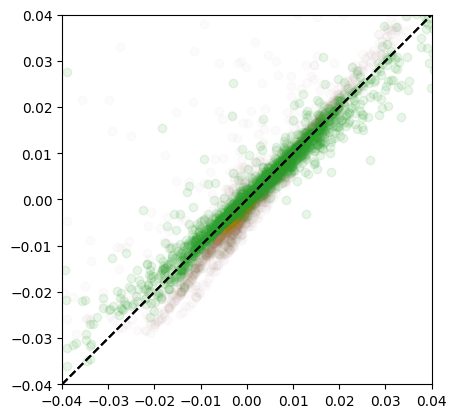

In [50]:
idx = 0
model = model_noneq
params = params_noneq
seed = 42
rng = np.random.RandomState(seed)
jax_key = jax.random.PRNGKey(seed)

R = test_data['R'][idx:idx+1]  # (1, natoms, 3)
Z = test_data['Z'][idx:idx+1]  # (1, natoms)
N = test_data['N'][idx:idx+1]  # (1,)
vdw_surface = test_data['vdw_surface'][idx:idx+1]  # (1, ngrid, 3)
TESTESP =  test_data['esp'][idx:idx+1]  # (1, ngrid, 3)
n_atoms = int(N[0])

graph = build_neighbor_graph(R, N)

# Original prediction
output_orig = predict_single(model, params, R, Z, N, vdw_surface, graph=graph)

# Test rotation
jax_key, rot_key, trans_key = jax.random.split(jax_key, 3)
rot_matrix = generate_random_rotation(rot_key)
R_rot = apply_rotation(R, rot_matrix)
vdw_rot = apply_rotation(vdw_surface, rot_matrix)

output_rot = predict_single(model, params, R_rot, Z, N, vdw_rot, graph=graph)

# For equivariant model: rotated output should equal rotation of original output
# Dipole should rotate
dipole_orig = jnp.asarray(output_orig['dipole'])
dipole_rot = jnp.asarray(output_rot['dipole'])
dipole_expected = jnp.einsum('ij,j->i', rot_matrix, dipole_orig)
rotation_error_dipole = jnp.linalg.norm(dipole_rot - dipole_expected)


# ESP should be identical at rotated grid points
esp_orig = jnp.asarray(output_orig['esp'])
esp_rot = jnp.asarray(output_rot['esp'])
rotation_error_esp = jnp.mean(jnp.abs(esp_rot - esp_orig))


# Test translation (both models should be translation invariant)
translation = 5.0 * jax.random.normal(trans_key, (3,), dtype=rot_matrix.dtype)
R_trans = apply_translation(R, translation)
vdw_trans = apply_translation(vdw_surface, translation)

output_trans = predict_single(model, params, R_trans, Z, N, vdw_trans, graph=graph)

# Dipole should be identical (molecule-centered)
dipole_trans = jnp.asarray(output_trans['dipole'])
translation_error_dipole = jnp.linalg.norm(dipole_trans - dipole_orig)


# ESP should be identical
esp_trans = jnp.asarray(output_trans['esp'])
translation_error_esp = jnp.mean(jnp.abs(esp_trans - esp_orig))


# Compare against reference quantities
true_energy = jnp.asarray(test_data['E'][idx])
energy_error = jnp.abs(jnp.asarray(output_orig['energy']) - true_energy)


true_dipole = jnp.asarray(test_data['Dxyz'][idx])
dipole_mae = jnp.mean(jnp.abs(dipole_orig - true_dipole))


true_forces = jnp.asarray(test_data['F'][idx])
if true_forces.ndim == 1:
    true_forces = true_forces.reshape(-1, 3)
forces_pred = jnp.asarray(output_orig['forces'])
forces_mae = jnp.mean(
    jnp.abs(forces_pred[:n_atoms] - true_forces[:n_atoms])
)
plt.scatter(output_orig['esp'], TESTESP, alpha=0.01)
for _ in [plt.ylim, plt.xlim]:
    _(-0.04, 0.04)
ax = plt.gca()
ax.set_aspect("equal")

plt.scatter(output_trans['esp'], TESTESP, alpha=0.01)
for _ in [plt.ylim, plt.xlim]:
    _(-0.04, 0.04)
ax = plt.gca()
ax.set_aspect("equal")
ax.plot([0,1],[0,1], transform=ax.transAxes, color="k", linestyle="--")

plt.scatter(output_orig['esp'], output_rot['esp'], alpha=0.1)
for _ in [plt.ylim, plt.xlim]:
    _(-0.04, 0.04)
ax = plt.gca()
ax.set_aspect("equal")

ax.plot([0,1],[0,1], transform=ax.transAxes, color="k", linestyle="--")

In [51]:
np.sqrt(np.mean((output_rot['esp'] - TESTESP)**2)) * 627.5

np.float32(32.54482)

In [52]:
np.sqrt(np.mean((output_trans['esp'] - output_orig['esp'])**2)) * 627.5

np.float32(1.0815712e-05)

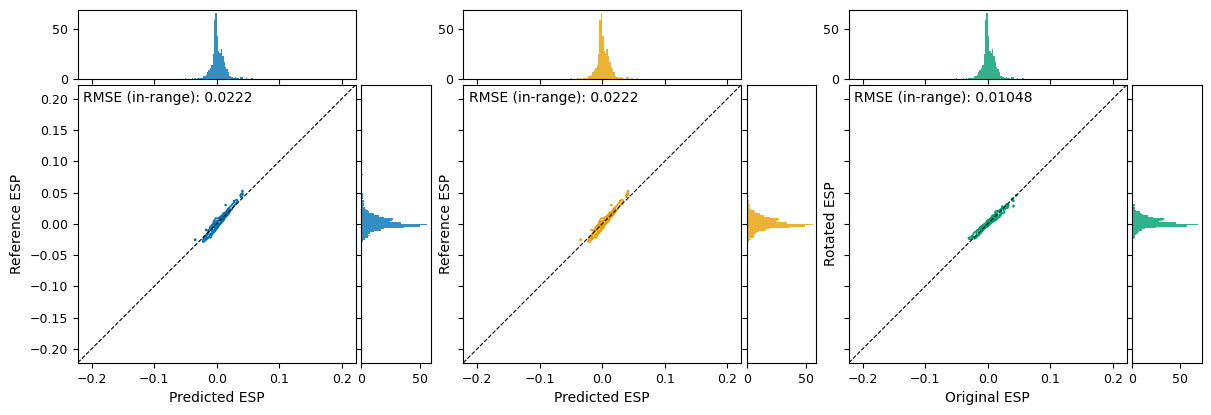

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# =========================
# CONFIG (no magic numbers)
# =========================
CFG = {
    "bounds_percentile": 99.5,            # symmetric axis limits from |values|
    "min_bins": 20,                       # FD lower clamp
    "max_bins": 200,                      # FD upper clamp
    "contour_percentiles": [70, 85, 93, 98],  # exactly 4 contour levels
    "line_width": 1.2,                    # contour line width
    "diag_width": 0.8,                    # diagonal line width
    "hist_alpha": 0.8,                    # marginal histogram alpha
    "hist_size_fraction": 0.25,           # tomography axes size as fraction of main axes
    "hist_pad_fraction": 0.02,            # padding as fraction of main axes
    "line_colors": {                      # Okabe–Ito-ish colors for lines
        "orig_vs_true":  "#0072B2",       # blue
        "trans_vs_true": "#E69F00",       # orange
        "rot_vs_orig":   "#009E73",       # green
    },
    "figsize": (12, 4.2),
    "title_size": 11,
    "label_size": 10,
    "tick_size": 9,
}

# =========================
# HELPERS
# =========================
def _finite(a):
    a = np.asarray(a).ravel()
    return a[np.isfinite(a)]

def _symmetric_limits(*arrays, p=99.5):
    vals = np.concatenate([_finite(a) for a in arrays]) if arrays else np.array([0.0])
    if vals.size == 0:
        return (-1.0, 1.0)
    L = np.nanpercentile(np.abs(vals), p)
    if not np.isfinite(L) or L == 0:
        L = np.max(np.abs(vals)) or 1.0
    return (-float(L), float(L))

def _fd_bins(x, min_bins, max_bins):
    x = _finite(x); n = x.size
    if n < 2:
        return min_bins
    q75, q25 = np.percentile(x, [75, 25])
    iqr = q75 - q25
    if iqr <= 0:
        bins = int(np.sqrt(max(n, 1)))
    else:
        h = 2 * iqr * n ** (-1/3)
        data_range = x.max() - x.min()
        bins = int(np.ceil(data_range / h)) if h > 0 else int(np.sqrt(max(n, 1)))
    return int(np.clip(bins, min_bins, max_bins))

def _hist2d_density(x, y, bins_x, bins_y, xlim, ylim):
    H, xedges, yedges = np.histogram2d(
        x, y, bins=[bins_x, bins_y], range=[xlim, ylim], density=True
    )
    return H.T, xedges, yedges

def _contour_levels_from_percentiles(density, percentiles):
    flat = density.ravel()
    flat = flat[(flat > 0) & np.isfinite(flat)]
    if flat.size == 0:
        # degenerate fallback
        return np.array([1e-12, 1e-10, 1e-8, 1e-6])
    levels = np.percentile(flat, percentiles)
    levels = np.unique(levels)
    if levels.size < 4:
        mn, mx = float(flat.min()), float(flat.max())
        if mx == mn:
            levels = mn * (1.0 + 1e-6 * np.arange(1, 5))
        else:
            levels = np.linspace(mn + 1e-12, mx, 4)
    return levels[:4]

def _rmse_in_limits(x, y, limits):
    x = _finite(x); y = _finite(y)
    m = (x >= limits[0]) & (x <= limits[1]) & (y >= limits[0]) & (y <= limits[1])
    if not np.any(m):
        return np.nan
    d = x[m] - y[m]
    return float(np.sqrt(np.mean(d * d)))

def plot_panel(ax_main, x, y, *, line_color, limits, cfg, title, xlabel, ylabel):
    """
    Unfilled 2D density contours (4 levels) + diagonal + marginal tomograms + RMSE annotation.
    """
    x = _finite(x); y = _finite(y)
    xlim = ylim = limits

    # Bins via FD
    bx = _fd_bins(x, cfg["min_bins"], cfg["max_bins"])
    by = _fd_bins(y, cfg["min_bins"], cfg["max_bins"])

    # Density grid
    H, xedges, yedges = _hist2d_density(x, y, bx, by, xlim, ylim)

    # Centers for contours
    Xc = 0.5 * (xedges[:-1] + xedges[1:])
    Yc = 0.5 * (yedges[:-1] + yedges[1:])
    X, Y = np.meshgrid(Xc, Yc)

    # Exactly 4 contour levels
    levels = _contour_levels_from_percentiles(H, cfg["contour_percentiles"])

    # Unfilled contour lines
    ax_main.contour(X, Y, H, levels=levels, colors=line_color, linewidths=cfg["line_width"])

    # Identity diagonal
    ax_main.plot([limits[0], limits[1]], [limits[0], limits[1]],
                 '--', color='k', linewidth=cfg["diag_width"])

    ax_main.set_xlim(limits); ax_main.set_ylim(limits); ax_main.set_aspect("equal")
    ax_main.set_title(title, fontsize=cfg["title_size"])
    ax_main.set_xlabel(xlabel, fontsize=cfg["label_size"])
    ax_main.set_ylabel(ylabel, fontsize=cfg["label_size"])
    ax_main.tick_params(labelsize=cfg["tick_size"])

    # RMSE (in-range)
    rmse = _rmse_in_limits(x, y, limits)
    ax_main.text(0.02, 0.98, f"RMSE (in-range): {rmse:.4g}",
                 transform=ax_main.transAxes, ha='left', va='top',
                 fontsize=cfg["label_size"])

    # ---- Tomography (marginal histograms) with FRACTION sizes ----
    divider = make_axes_locatable(ax_main)
    size_str = f"{cfg['hist_size_fraction']*100:.1f}%"   # e.g., "25.0%"
    pad_str  = f"{cfg['hist_pad_fraction']*100:.2f}%"

    ax_top   = divider.append_axes("top",  size=size_str, pad=pad_str, sharex=ax_main)
    ax_right = divider.append_axes("right", size=size_str, pad=pad_str, sharey=ax_main)

    # X projection
    bins_x = _fd_bins(x, cfg["min_bins"], cfg["max_bins"])
    ax_top.hist(x[(x>=limits[0]) & (x<=limits[1])], bins=bins_x, range=limits,
                color=line_color, alpha=cfg["hist_alpha"], density=True)
    ax_top.tick_params(labelbottom=False, labelsize=cfg["tick_size"])
    ax_top.set_xlim(limits)

    # Y projection
    bins_y = _fd_bins(y, cfg["min_bins"], cfg["max_bins"])
    ax_right.hist(y[(y>=limits[0]) & (y<=limits[1])], bins=bins_y, range=limits,
                  color=line_color, alpha=cfg["hist_alpha"], density=True, orientation='horizontal')
    ax_right.tick_params(labelleft=False, labelsize=cfg["tick_size"])
    ax_right.set_ylim(limits)

# =========================
# DATA EXTRACT (ESP arrays)
# =========================
esp_pred_orig  = np.asarray(output_orig['esp']).ravel()
esp_pred_rot   = np.asarray(output_rot['esp']).ravel()
esp_pred_trans = np.asarray(output_trans['esp']).ravel()
esp_true       = np.asarray(TESTESP).ravel()

# Shared robust symmetric limits across all panels
limits = _symmetric_limits(esp_pred_orig, esp_pred_rot, esp_pred_trans, esp_true,
                           p=CFG["bounds_percentile"])

# =========================
# PLOT (3 panels)
# =========================
fig, axes = plt.subplots(1, 3, figsize=CFG["figsize"], constrained_layout=True, sharex=True, sharey=True)

plot_panel(
    axes[0],
    esp_pred_orig, esp_true,
    line_color=CFG["line_colors"]["orig_vs_true"],
    limits=limits, cfg=CFG,
    title="Original vs True ESP",
    xlabel="Predicted ESP", ylabel="Reference ESP"
)

plot_panel(
    axes[1],
    esp_pred_trans, esp_true,
    line_color=CFG["line_colors"]["trans_vs_true"],
    limits=limits, cfg=CFG,
    title="Translated vs True ESP",
    xlabel="Predicted ESP", ylabel="Reference ESP"
)

plot_panel(
    axes[2],
    esp_pred_orig, esp_pred_rot,
    line_color=CFG["line_colors"]["rot_vs_orig"],
    limits=limits, cfg=CFG,
    title="Rotated vs Original ESP",
    xlabel="Original ESP", ylabel="Rotated ESP"
)

plt.show()
